## Walktimes to CCC
# Introduction

In this tutorial we will analyse walk times from address points within the City of Toronto to the Toronto Transit Commission (TTC) Stops. CCCs can include subway, LRT, street car and bus. The analysis will use Panada to perform the network calculation. The results will be displayed City wide and at the level of an individual City of Toronto Neighbourhood Improvement Area. Neighbourhood Improvement Areas have been chosen as one of the domains used to determine them is the physical surroundings including access to transportation.

The analysis will use data from the City of Toronto's Open Data site including CCC (https://open.toronto.ca/dataset/ttc-routes-and-schedules/), the City of Toronto's pedestrian network (https://open.toronto.ca/dataset/pedestrian-network/), Toronto One Address Repository address point data (https://open.toronto.ca/dataset/address-points-municipal-toronto-one-address-repository/) and Neighbourhood Improvement Areas (https://open.toronto.ca/dataset/neighbourhood-improvement-areas/).

The TTC Routes and Schedules zip file contains route definitions, stop patterns, stop locations, and schedules. For this tutorial we will be using the stops.txt file.

The City of Toronto pedestrian network was a collective effort by the City of Toronto's Information and Technology Division's Data Analytics and Visualization team (DAV) and the City of Toronto's Transportation Services Division. A pedestrian network based on sidewalk centerlines and pedestrian-assets (e.g., sidewalks, crosswalks, pedestrian controlled crossings) was created with the focus being placed on the topological consistency over spatial accuracy. Meaning that the sidewalk centerlines are not necessarily spatially located along with the actual locations of the sidewalk geographically, but the connections between different sidewalk segments were maintained as being a higher priority.

The City of Toronto address point data contains over 500,000 address points within the city. A readme file is also included which explains the each of the attributes.

Neighbourhood Improvement Areas are specially-selected and designated neighbourhoods in the City of Toronto found to have inequities on several indicators of well-being. Currently 31 out of 140 neighbourhoods are designated as NIAs as part of the Toronto Strong Neighbourhoods 2020 (TSNS2020) project. Please see the link for further information (https://www.toronto.ca/city-government/data-research-maps/research-reports/social-reports/toronto-strong-neighbourhoods-strategy-2020/).

In [2]:
!pip install geopandas

  Using cached geopandas-0.12.1-py3-none-any.whl (1.1 MB)
  Using cached pyproj-3.4.0-cp38-cp38-win_amd64.whl (4.8 MB)
  Using cached Fiona-1.8.22-cp38-cp38-win_amd64.whl (21.7 MB)
  Using cached Shapely-1.8.5.post1-cp38-cp38-win_amd64.whl (1.3 MB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osmnx 1.2.2 requires numpy>=1.22, but you have numpy 1.21.5 which is incompatible.
osmnx 1.2.2 requires pandas>=1.4, but you have pandas 1.3.3 which is incompatible.
osmnx 1.2.2 requires Rtree>=1.0, but you have rtree 0.9.7 which is incompatible.


In [4]:
!pip install psycopg2

     ---------------------------------------- 1.2/1.2 MB 36.8 MB/s eta 0:00:00


In [3]:
!pip install pandana

     -------------------------------------- 130.2/130.2 kB 1.9 MB/s eta 0:00:00
     ---------------------------------------- 3.1/3.1 MB 14.3 MB/s eta 0:00:00
     ---------------------------------------- 92.7/92.7 kB 5.2 MB/s eta 0:00:00


In [17]:
!pip install basemap --user

  Using cached basemap-1.3.6-cp38-cp38-win_amd64.whl (487 kB)
  Using cached basemap_data-1.3.2-py2.py3-none-any.whl (30.5 MB)
  Using cached contourpy-1.0.6-cp38-cp38-win_amd64.whl (163 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.4.0 requires matplotlib<3.6,>=3.2, but you have matplotlib 3.6.2 which is incompatible.


In [19]:
!pip install geoalchemy2

     ---------------------------------------- 50.5/50.5 kB ? eta 0:00:00


In [21]:
!pip install mapclassify

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandana as pdna
import networkx as nx
from shapely.geometry import LineString
%matplotlib inline

## Step 1: Importing and Cleaning Data
# Importing Data
We can read the CCC text file and create geometry using the latitude longitude columns supplied in the data. We can use the geopandas.read_file function to read the pednet, address and Neighbourhood Improvement Areas ESRI shape files and reproject them to EPSG 2019. Please see the link for the description of EPSG 2019 (https://epsg.io/2019).

# Read CCC Data
Read the CCC data text file and create the spatial layer using the latitude and longitude provided in the file. The layer will be reprojected to EPSG 2019.

In [5]:
# reading CCC csv file
# https://open.toronto.ca/dataset/ttc-routes-and-schedules/
# Go to Download Data
ccc = pd.read_csv('Child care centres - 2945.csv')
ccc

_id  LOC_ID                                           LOC_NAME  \
0        1    1013              Lakeshore Community Child Care Centre   
1        2    1014            Alternative Primary School Parent Group   
2        3    1015     Cardinal Leger Child Care Centre (Scarborough)   
3        4    1016  George Brown - Richmond Adelaide Childcare Centre   
4        5    1017  Woodland Nursery School (Warden Woods Communit...   
...    ...     ...                                                ...   
1041  1042   14333                               Gan Chabad Preschool   
1042  1043   14335                                  Atelier Kids Inc.   
1043  1044   14336                         Westside Montessori School   
1044  1045   14338    The Neighbourhood Group Harbourfront Child Care   
1045  1046   14339                 The Neighbourhood Group Waterfront   

                AUSPICE            ADDRESS    PCODE  ward               PHONE  \
0     Non Profit Agency     101 SEVENTH ST  M8V 3B5     3      (416) 394-7601   
1     Non Profit Agency    1100 SPADINA RD  M5N 2M6     8      (416) 322-5385   
2     Non Profit Agency     600 MORRISH RD  M1C 4Y1    25      (416) 287-0578   
3     Non Profit Agency  130 ADELAIDE ST W  M5H 3P5    10      (416) 415-2453   
4     Non Profit Agency    1 FIRVALLEY CRT  M1L 1N8    20  (416) 694-1138x163   
...                 ...                ...      ...   ...                 ...   
1041  Non Profit Agency   147 OVERBROOK PL  M3H 4R1     6      (416) 635-9696   
1042  Commercial Agency      21 QUEBEC AVE  M6P 2T3     4      (416) 419-3864   
1043  Commercial Agency      57 SYLVAN AVE  M6H 1G4     9      (647) 400-6521   
1044  Non Profit Agency  650 QUEENS QUAY W  M5V 3N2    10                 NaN   
1045  Non Profit Agency  635 QUEENS QUAY W  M5V 3G3    10                 NaN   

                       bldg_type                         BLDGNAME  IGSPACE  \
0       Public Elementary School     Seventh Street Public School        0   
1       Public Elementary School  North Preparatory Public School        0   
2     Catholic Elementary School   Cardinal Leger Catholic School        0   
3                          Other                              NaN       10   
4            High Rise Apartment                              NaN        0   
...                          ...                              ...      ...   
1041                       Other                              NaN        0   
1042                       Other                              NaN        0   
1043                       Other                              NaN        0   
1044         High Rise Apartment                              NaN       16   
1045                       Other                              NaN        0   

      TGSPACE  PGSPACE  KGSPACE  SGSPACE  TOTSPACE subsidy run_date  \
0          20       32       52       60       164       Y  21APR22   
1           0       12       26       45        83       Y  21APR22   
2          10       16       26       50       102       Y  21APR22   
3          15       40        0        0        65       Y  21APR22   
4          10       16        0        0        26       Y  21APR22   
...       ...      ...      ...      ...       ...     ...      ...   
1041       15       43        0        0        58       N  21APR22   
1042        0       20       24        0        44       N  21APR22   
1043       12       23        0        0        35       N  21APR22   
1044       20        0        0        0        36       Y  21APR22   
1045        0       40       52       60       152       Y  21APR22   

                                               geometry  
0     {'type': 'Point', 'coordinates': (-1392098.168...  
1     {'type': 'Point', 'coordinates': (-1382218.055...  
2     {'type': 'Point', 'coordinates': (-1359925.521...  
3     {'type': 'Point', 'coordinates': (-1380912.770...  
4     {'type': 'Point', 'coordinates': (-1371061.855...  
...                

In [10]:
# Let's check out the .shp file instead (same dataset)
ccc = gpd.read_file('Child care centres.shp')
ccc

_id  LOC_ID                                           LOC_NAME  \
0        1    1013              Lakeshore Community Child Care Centre   
1        2    1014            Alternative Primary School Parent Group   
2        3    1015     Cardinal Leger Child Care Centre (Scarborough)   
3        4    1016  George Brown - Richmond Adelaide Childcare Centre   
4        5    1017  Woodland Nursery School (Warden Woods Communit...   
...    ...     ...                                                ...   
1050  1051   14373                    Waverley Road Montessori School   
1051  1052   14374                            Angus Valley Montessori   
1052  1053   14375                             Blue Bell Academy Inc.   
1053  1054   14377                                 The Toronto Cheder   
1054  1055   14390                           Le Jardin De Moliere Inc   

                AUSPICE                 ADDRESS    PCODE  ward  \
0     Non Profit Agency          101 SEVENTH ST  M8V 3B5     3   
1     Non Profit Agency         1100 SPADINA RD  M5N 2M6     8   
2     Non Profit Agency          600 MORRISH RD  M1C 4Y1    25   
3     Non Profit Agency       130 ADELAIDE ST W  M5H 3P5    10   
4     Non Profit Agency         1 FIRVALLEY CRT  M1L 1N8    20   
...                 ...                     ...      ...   ...   
1050  Commercial Agency         646 KINGSTON RD  M4E 1P9    19   
1051  Commercial Agency           4841 YONGE ST  M2N 5X2    18   
1052  Commercial Agency       1415 GERRARD ST E  M4L 1Z5    14   
1053  Non Profit Agency        475 PATRICIA AVE  M2R 2N1    18   
1054  Commercial Agency  3029 LAKE SHORE BLVD W  M8V 1K5     3   

                   PHONE                   bldg_type  \
0         (416) 394-7601    Public Elementary School   
1         (416) 322-5385    Public Elementary School   
2         (416) 287-0578  Catholic Elementary School   
3         (416) 415-2453                       Other   
4     (416) 694-1138x163         High Rise Apartment   
...                  ...                         ...   
1050      (647) 351-1600                       Other   
1051      (416) 723-1155                       Other   
1052      (416) 550-4442                       Other   
1053  (416) 636-2987x254                       Other   
1054      (647) 774-8628                       Other   

                             BLDGNAME  IGSPACE  TGSPACE  PGSPACE  KGSPACE  \
0        Seventh Street Public School      0.0     20.0     32.0     52.0   
1     North Preparatory Public School      0.0      0.0     12.0     26.0   
2      Cardinal Leger Catholic School      0.0     10.0     16.0     26.0   
3                                None     10.0     15.0     40.0      0.0   
4                                None      0.0     10.0     16.0      0.0   
...                               ...      ...      ...      ...      ...   
1050                             None      0.0     10.0     36.0      0.0   
1051                             None      0.0     19.0     40.0      0.0   
1052                             None     10.0     20.0      8.0      0.0   
1053                             None      0.0      0.0     20.0      0.0   
1054                             None      NaN      NaN      NaN      NaN   

      SGSPACE  TOTSPACE subsidy run_date                    geometry  
0        60.0     164.0       Y  07NOV22  POINT (-79.50419 43.59992)  
1        45.0      83.0       Y  07NOV22  POINT (-79.42037 43.70577)  
2        50.0     102.0       Y  07NOV22  POINT (-79.17546 43.79329)  
3         0.0      65.0       Y  07NOV22  POINT (-79.38381 43.64969)  
4         0.0      26.0       Y  07NOV22  POINT (-79.28103 43.70295)  
...       ...       ...     ...      ...                         ...  
1050      0.0      46.0       N  07NOV22  POINT (-79.29868 43.67890)  
1051      0.0      59.0       N  07NOV22  POINT (-79.41077 43.76240)  
1052      0.0      38.0       N  07NOV22  POINT (-79.32300 43.67185)  
1053      0.0      20.0      

In [11]:
#include columns needed for the project and renaming stop_lat and stop_lon columns
ccc = ccc[['_id', 'LOC_ID','LOC_NAME','geometry']]
# ccc = ccc.rename(columns={'stop_lat': 'latitude','stop_lon':'longitude' })
ccc

_id  LOC_ID                                           LOC_NAME  \
0        1    1013              Lakeshore Community Child Care Centre   
1        2    1014            Alternative Primary School Parent Group   
2        3    1015     Cardinal Leger Child Care Centre (Scarborough)   
3        4    1016  George Brown - Richmond Adelaide Childcare Centre   
4        5    1017  Woodland Nursery School (Warden Woods Communit...   
...    ...     ...                                                ...   
1050  1051   14373                    Waverley Road Montessori School   
1051  1052   14374                            Angus Valley Montessori   
1052  1053   14375                             Blue Bell Academy Inc.   
1053  1054   14377                                 The Toronto Cheder   
1054  1055   14390                           Le Jardin De Moliere Inc   

                        geometry  
0     POINT (-79.50419 43.59992)  
1     POINT (-79.42037 43.70577)  
2     POINT (-79.17546 43.79329)  
3     POINT (-79.38381 43.64969)  
4     POINT (-79.28103 43.70295)  
...                          ...  
1050  POINT (-79.29868 43.67890)  
1051  POINT (-79.41077 43.76240)  
1052  POINT (-79.32300 43.67185)  
1053  POINT (-79.44440 43.78381)  
1054  POINT (-79.50886 43.59977)  

[1055 rows x 4 columns]

In [12]:
# create geopanda dataframe add crs lat long
# ccc['geometry'] = list(zip(ccc.longitude, ccc.latitude))
# ccc['geometry'] = ccc['geometry'].apply(Point)

# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
crs = {'init': 'epsg:2945'}
ccc = gpd.GeoDataFrame(ccc, crs=crs, geometry='geometry')
ccc = ccc.to_crs({'init': 'epsg:2019'})

# calculating x and y which will be used later to find nearest CCC to address
ccc['x'] = ccc.geometry.x
ccc['y'] = ccc.geometry.y

C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [13]:
ccc.crs

<Projected CRS: EPSG:2019>
Name: NAD27(76) / MTM zone 10
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada - Ontario - between 81°W and 78°W: south of 46°N in area to west of 80°15'W, south of 47°N in area between 80°15'W and 79°30'W, entire province between 79°30'W and 78°W.
- bounds: (-81.0, 42.26, -77.99, 47.33)
Coordinate Operation:
- name: MTM zone 10
- method: Transverse Mercator
Datum: North American Datum 1927 (1976)
- Ellipsoid: Clarke 1866
- Prime Meridian: Greenwich

In [14]:
ccc

_id  LOC_ID                                           LOC_NAME  \
0        1    1013              Lakeshore Community Child Care Centre   
1        2    1014            Alternative Primary School Parent Group   
2        3    1015     Cardinal Leger Child Care Centre (Scarborough)   
3        4    1016  George Brown - Richmond Adelaide Childcare Centre   
4        5    1017  Woodland Nursery School (Warden Woods Communit...   
...    ...     ...                                                ...   
1050  1051   14373                    Waverley Road Montessori School   
1051  1052   14374                            Angus Valley Montessori   
1052  1053   14375                             Blue Bell Academy Inc.   
1053  1054   14377                                 The Toronto Cheder   
1054  1055   14390                           Le Jardin De Moliere Inc   

                            geometry              x             y  
0     POINT (304461.400 4828671.905)  304461.400215  4.828672e+06  
1     POINT (311217.446 4840433.213)  311217.445605  4.840433e+06  
2     POINT (330918.335 4850204.630)  330918.335077  4.850205e+06  
3     POINT (314172.949 4834207.161)  314172.948870  4.834207e+06  
4     POINT (322448.989 4840140.901)  322448.989348  4.840141e+06  
...                              ...            ...           ...  
1050  POINT (321032.612 4837465.207)  321032.612126  4.837465e+06  
1051  POINT (311984.847 4846725.255)  311984.847024  4.846725e+06  
1052  POINT (319073.539 4836677.974)  319073.538824  4.836678e+06  
1053  POINT (309274.974 4849102.036)  309274.974212  4.849102e+06  
1054  POINT (304084.857 4828654.782)  304084.857185  4.828655e+06  

[1055 rows x 6 columns]

### Explore CCC

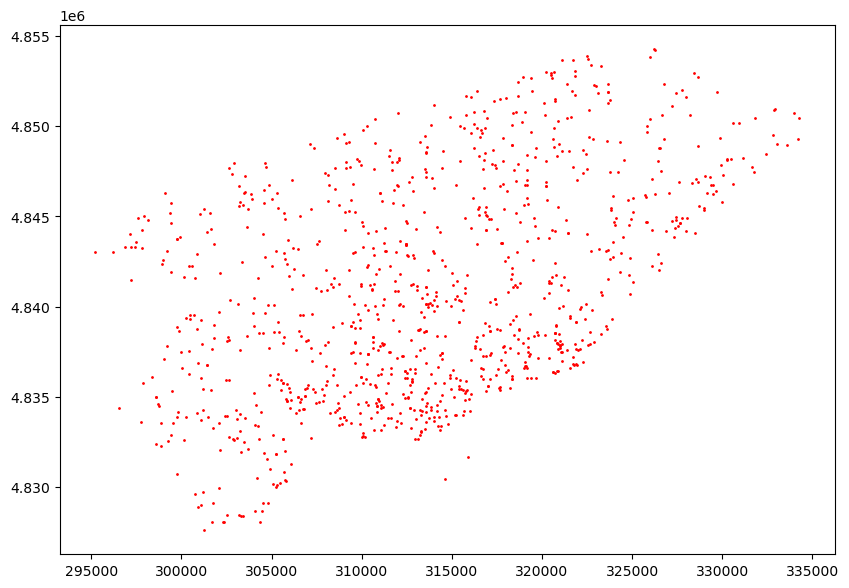

In [15]:
ax = ccc.plot(figsize=(10, 10),color='red', markersize =1)

## Read Pedestrian Network Data
Read the Pedestrian Network line shape file and reproject to EPSG 2019

In [16]:
# reading pednet file
pednet = gpd.read_file("Pedestrian Network Data - 4326.zip")
pednet

FIELD_1  FIELD_2    FIELD_3  FIELD_4                      FIELD_5  \
0       696841        1      Local        7       Sidewalk on both sides   
1       696842        2  Collector        7       Sidewalk on both sides   
2       696843        3       None        2  Sidewalk on north side only   
3       696844        4       None        7       Sidewalk on both sides   
4       696845        5      Local        7       Sidewalk on both sides   
...        ...      ...        ...      ...                          ...   
87100   783941    87101    Walkway       11                 City walkway   
87101   783942    87102    Walkway       11                 City walkway   
87102   783943    87103    Walkway       11                 City walkway   
87103   783944    87104    Walkway       11                 City walkway   
87104   783945    87105    Walkway       11                 City walkway   

       FIELD_6 FIELD_7  FIELD_8 FIELD_9    FIELD_10    FIELD_11  \
0            0    None      NaN    None   93.867680  129.824322   
1            0    None      NaN    None   32.546284   44.903807   
2            0    None      NaN    None  117.669206  162.522572   
3            0    None      NaN    None  223.269710  309.035596   
4            0    None      NaN    None  201.335648  278.478601   
...        ...     ...      ...     ...         ...         ...   
87100        1      ts   1430.0      ts   32.249129   44.584927   
87101        1      ts   1174.0      ts   26.786411   37.023492   
87102        1      ts    888.0      ts   32.846849   45.381530   
87103        1      ts   2137.0      ts   30.031629   41.511419   
87104        1      ts   1867.0      ts   21.617733   29.843369   

                                                geometry  
0      LINESTRING (-79.56396 43.73782, -79.56293 43.7...  
1      LINESTRING (-79.56792 43.63618, -79.56752 43.6...  
2      LINESTRING (-79.37791 43.67845, -79.37652 43.6...  
3      LINESTRING (-79.51852 43.70501, -79.51674 43.7...  
4      LINESTRING (-79.30122 43.77484, -79.29880 43.7...  
...                                                  ...  
87100  LINESTRING (-79.57840 43.73537, -79.57803 43.7...  
87101  LINESTRING (-79.57050 43.71929, -79.57019 43.7...  
87102  LINESTRING (-79.56002 43.69689, -79.55964 43.6...  
87103  LINESTRING (-79.57363 43.72572, -79.57327 43.7...  
87104  LINESTRING (-79.53773 43.64694, -79.53748 43.6...  

[87105 rows x 12 columns]

In [17]:
pednet.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
crs = {'init': 'epsg:4326'}
pednet = gpd.GeoDataFrame(pednet, crs=crs, geometry='geometry')
pednet = pednet.to_crs({'init': 'epsg:2019'})

C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [19]:
# remove length column to avoid confusion
# pednet = pednet[['OBJECTID', 'road_type', 'sdwlk_code', 'sdwlk_desc', 'crosswalk', 'cwalk_type', 'px', 'px_type','geometry']]
pednet = pednet[['FIELD_1', 'FIELD_3', 'FIELD_4', 'FIELD_5', 'FIELD_6', 'FIELD_7', 'FIELD_8', 'FIELD_9','geometry']]
pednet

FIELD_1    FIELD_3  FIELD_4                      FIELD_5  FIELD_6  \
0       696841      Local        7       Sidewalk on both sides        0   
1       696842  Collector        7       Sidewalk on both sides        0   
2       696843       None        2  Sidewalk on north side only        0   
3       696844       None        7       Sidewalk on both sides        0   
4       696845      Local        7       Sidewalk on both sides        0   
...        ...        ...      ...                          ...      ...   
87100   783941    Walkway       11                 City walkway        1   
87101   783942    Walkway       11                 City walkway        1   
87102   783943    Walkway       11                 City walkway        1   
87103   783944    Walkway       11                 City walkway        1   
87104   783945    Walkway       11                 City walkway        1   

      FIELD_7  FIELD_8 FIELD_9  \
0        None      NaN    None   
1        None      NaN    None   
2        None      NaN    None   
3        None      NaN    None   
4        None      NaN    None   
...       ...      ...     ...   
87100      ts   1430.0      ts   
87101      ts   1174.0      ts   
87102      ts    888.0      ts   
87103      ts   2137.0      ts   
87104      ts   1867.0      ts   

                                                geometry  
0      LINESTRING (299647.480 4843993.305, 299730.645...  
1      LINESTRING (299319.487 4832701.797, 299351.915...  
2      LINESTRING (314644.016 4837403.152, 314756.028...  
3      LINESTRING (303307.301 4840346.899, 303450.851...  
4      LINESTRING (320802.305 4848122.923, 320996.750...  
...                                                  ...  
87100  LINESTRING (298484.120 4843722.537, 298514.329...  
87101  LINESTRING (299119.187 4841934.761, 299144.363...  
87102  LINESTRING (299961.620 4839445.526, 299992.729...  
87103  LINESTRING (298868.080 4842649.076, 298896.374...  
87104  LINESTRING (301756.197 4833895.912, 301776.423...  

[87105 rows x 9 columns]

## Explore the Pedestrian Network Data
Create bar plot and plots of pednet

Create a bar plot showing the distribution of road types

<AxesSubplot:title={'center':'Pednet Road Type Distribution'}, xlabel='Road Types ', ylabel='Number'>

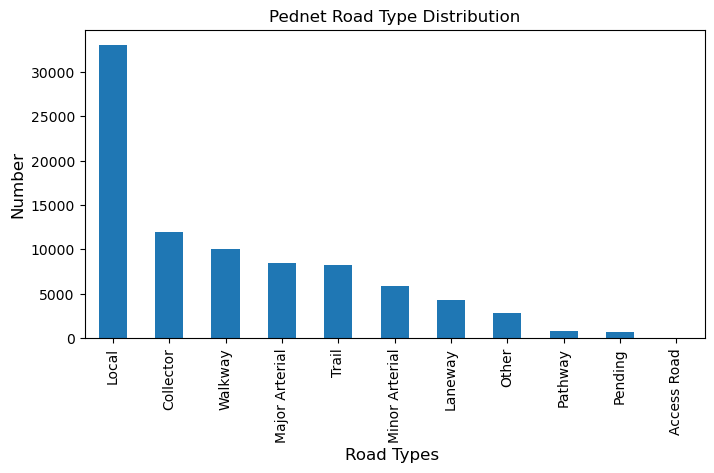

In [20]:
# distribution of road types in pednet

#plot
plt.figure(figsize=(8,4))
#ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Pednet Road Type Distribution")
plt.ylabel('Number', fontsize=12)
plt.xlabel('Road Types ', fontsize=12)

pednet.FIELD_3.value_counts().plot.bar()

### Create a plot of the city wide Pedestrian Network

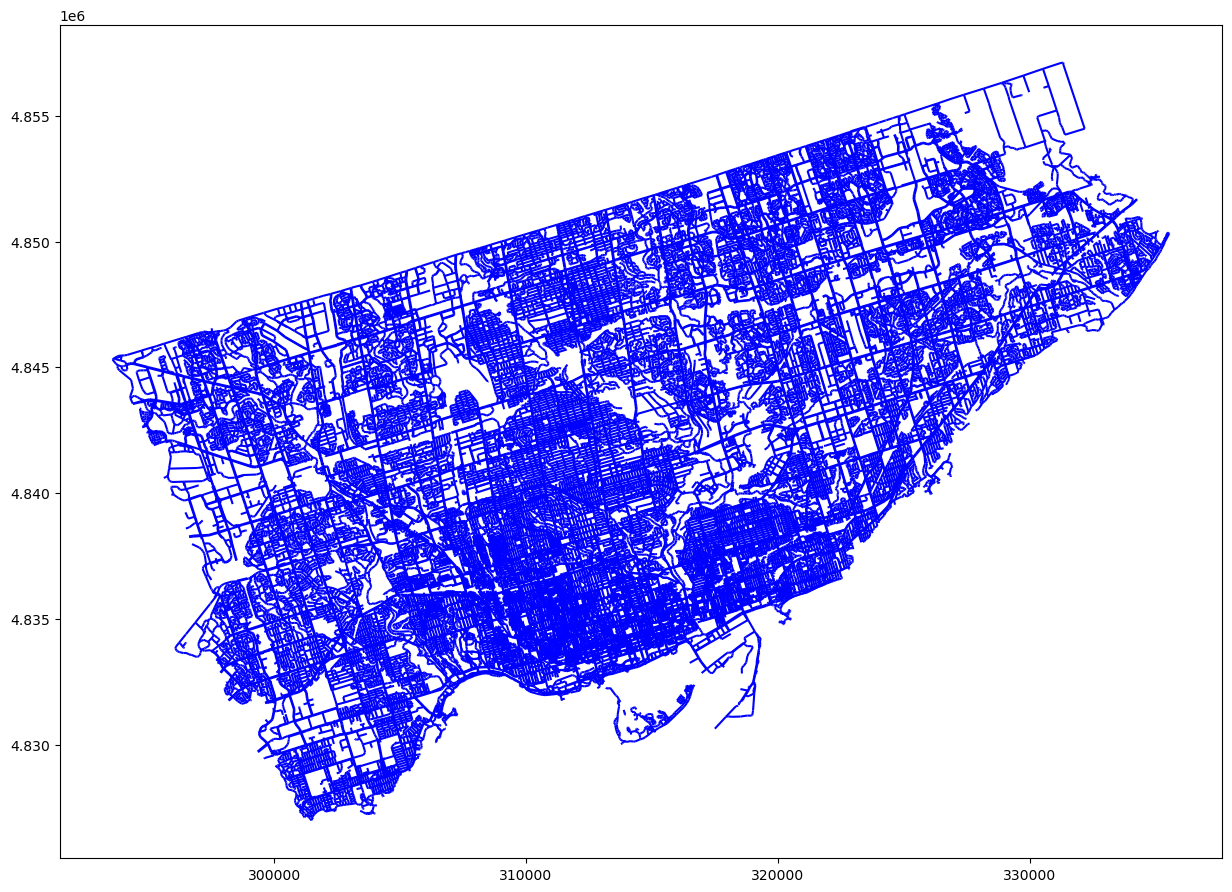

In [21]:
# plotting pednet layer
ax = pednet.plot(figsize=(15, 15),color='blue', markersize =1)

### Create a plot showing the Pedestrian Network at the city block level
In the plot below we see the cases where sidewalks are on both sides of the streets. Single lines represent several different features including local roads, walkways, laneways or private roads.

[(311000.0, 312000.0), (4834000.0, 4835000.0)]

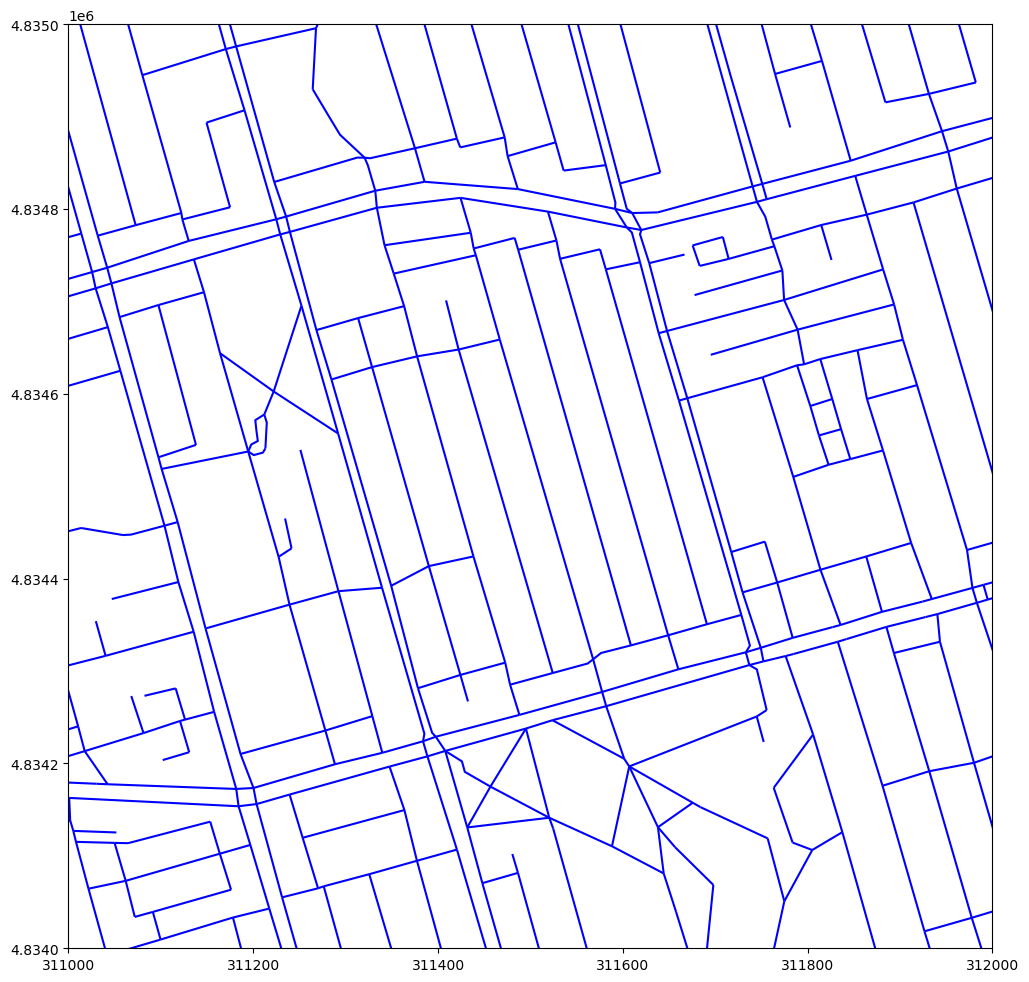

In [22]:
# plotting pednet layer with limits set
ax = pednet.plot(figsize=(12, 12),color='blue', markersize =1)
ax.set(xlim=(311000, 312000), ylim=(4834000, 4835000))

## Load Address Data
Read the Address point shape file and reproject to EPSG 2019

In [23]:
# reading municipal address point shape file
# https://open.toronto.ca/dataset/address-points-municipal-toronto-one-address-repository/
# Go to Download Data
address = gpd.read_file("Municipal address points (wgs84) - geojson.zip")
address

GEO_ID      LINK MAINT_STAG ADDRESS            LFNAME  LO_NUM  \
0        5729529   5729516    REGULAR     399    Lake Promenade     399   
1        9950585   9950578    REGULAR       7           Hilo Rd       7   
2        5729496   5729468    REGULAR     387    Lake Promenade     387   
3        5729341   5729332    REGULAR     321    Lake Promenade     321   
4        7304577   7304570    REGULAR      22   Thirty Sixth St      22   
...          ...       ...        ...     ...               ...     ...   
525470  30090978  11130066    REGULAR     935    Eglinton Ave W     935   
525471  30098425    437784    REGULAR     180  Fairview Mall Dr     180   
525472  30098430  30134630    REGULAR      17    Allenbury Gdns      17   
525473  30112831    437784    REGULAR     188  Fairview Mall Dr     188   
525474  30107192    112267    REGULAR     43B           Park St      43   

       LONUMSUF  HINUM HINUMSUF ARC_SIDE  ...      CLASS  NAME           X  \
0          None    NaN     None        L  ...       Land  None  301607.151   
1          None    NaN     None        L  ...       Land  None  301540.011   
2          None    NaN     None        L  ...       Land  None  301648.488   
3          None    NaN     None        L  ...       Land  None  301926.249   
4          None    NaN     None        L  ...       Land  None  301937.384   
...         ...    ...      ...      ...  ...        ...   ...         ...   
525470     None    NaN     None        L  ...       Land  None  310615.385   
525471     None    NaN     None        L  ...       Land  None  317534.188   
525472     None    NaN     None        R  ...  Structure  None  317491.442   
525473     None    NaN     None        L  ...       Land  None  317563.408   
525474        B    NaN     None        R  ...       Land  None  324486.414   

                  Y  LONGITUDE   LATITUDE  OBJECTID     MUN_NAME  \
0       4827443.931 -79.539542  43.586930   1491585    Etobicoke   
1       4827592.989 -79.540374  43.588272   1491586    Etobicoke   
2       4827472.065 -79.539030  43.587184   1491591    Etobicoke   
3       4827620.088 -79.535591  43.588517   1491594    Etobicoke   
4       4827737.920 -79.535454  43.589578   1491597    Etobicoke   
...             ...        ...        ...       ...          ...   
525470  4840045.680 -79.427849  43.700339   4611196         York   
525471  4848943.535 -79.341798  43.780343   4613003   North York   
525472  4848985.955 -79.342329  43.780726   4613012   North York   
525473  4848985.222 -79.341434  43.780718   4613018   North York   
525474  4841160.336 -79.255714  43.710134   4614642  Scarborough   

                    WARD_NAME                    geometry  
0         Etobicoke-Lakeshore  POINT (-79.53954 43.58692)  
1         Etobicoke-Lakeshore  POINT (-79.54037 43.58826)  
2         Etobicoke-Lakeshore  POINT (-79.53903 43.58717)  
3         Etobicoke-Lakeshore  POINT (-79.53559 43.58851)  
4         Etobicoke-Lakeshore  POINT (-79.53545 43.58957)  
...                       ...                         ...  
525470     Toronto-St. Paul's  POINT (-79.42785 43.70034)  
525471       Don Valley North  POINT (-79.34180 43.78034)  
525472       Don Valley North  POINT (-79.34233 43.78073)  
525473       Don Valley North  POINT (-79.34143 43.78072)  
525474  Scarborough Southwest  POINT (-79.25571 43.71013)  

[525475 rows x 23 columns]

In [24]:
# change column names from upper to lower case
address.columns = map(str.lower, address.columns)

#include columns needed for the project
address = address[['geo_id', 'maint_stag','address','lfname','x','y','longitude','latitude','objectid','mun_name','ward_name','geometry']]
address

geo_id maint_stag address            lfname           x  \
0        5729529    REGULAR     399    Lake Promenade  301607.151   
1        9950585    REGULAR       7           Hilo Rd  301540.011   
2        5729496    REGULAR     387    Lake Promenade  301648.488   
3        5729341    REGULAR     321    Lake Promenade  301926.249   
4        7304577    REGULAR      22   Thirty Sixth St  301937.384   
...          ...        ...     ...               ...         ...   
525470  30090978    REGULAR     935    Eglinton Ave W  310615.385   
525471  30098425    REGULAR     180  Fairview Mall Dr  317534.188   
525472  30098430    REGULAR      17    Allenbury Gdns  317491.442   
525473  30112831    REGULAR     188  Fairview Mall Dr  317563.408   
525474  30107192    REGULAR     43B           Park St  324486.414   

                  y  longitude   latitude  objectid     mun_name  \
0       4827443.931 -79.539542  43.586930   1491585    Etobicoke   
1       4827592.989 -79.540374  43.588272   1491586    Etobicoke   
2       4827472.065 -79.539030  43.587184   1491591    Etobicoke   
3       4827620.088 -79.535591  43.588517   1491594    Etobicoke   
4       4827737.920 -79.535454  43.589578   1491597    Etobicoke   
...             ...        ...        ...       ...          ...   
525470  4840045.680 -79.427849  43.700339   4611196         York   
525471  4848943.535 -79.341798  43.780343   4613003   North York   
525472  4848985.955 -79.342329  43.780726   4613012   North York   
525473  4848985.222 -79.341434  43.780718   4613018   North York   
525474  4841160.336 -79.255714  43.710134   4614642  Scarborough   

                    ward_name                    geometry  
0         Etobicoke-Lakeshore  POINT (-79.53954 43.58692)  
1         Etobicoke-Lakeshore  POINT (-79.54037 43.58826)  
2         Etobicoke-Lakeshore  POINT (-79.53903 43.58717)  
3         Etobicoke-Lakeshore  POINT (-79.53559 43.58851)  
4         Etobicoke-Lakeshore  POINT (-79.53545 43.58957)  
...                       ...                         ...  
525470     Toronto-St. Paul's  POINT (-79.42785 43.70034)  
525471       Don Valley North  POINT (-79.34180 43.78034)  
525472       Don Valley North  POINT (-79.34233 43.78073)  
525473       Don Valley North  POINT (-79.34143 43.78072)  
525474  Scarborough Southwest  POINT (-79.25571 43.71013)  

[525475 rows x 12 columns]

In [25]:
address.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [26]:
# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
crs = {'init': 'epsg:4326'}
address = gpd.GeoDataFrame(address, crs=crs, geometry='geometry')
address = address.to_crs({'init': 'epsg:2019'})

C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### Explore address point data

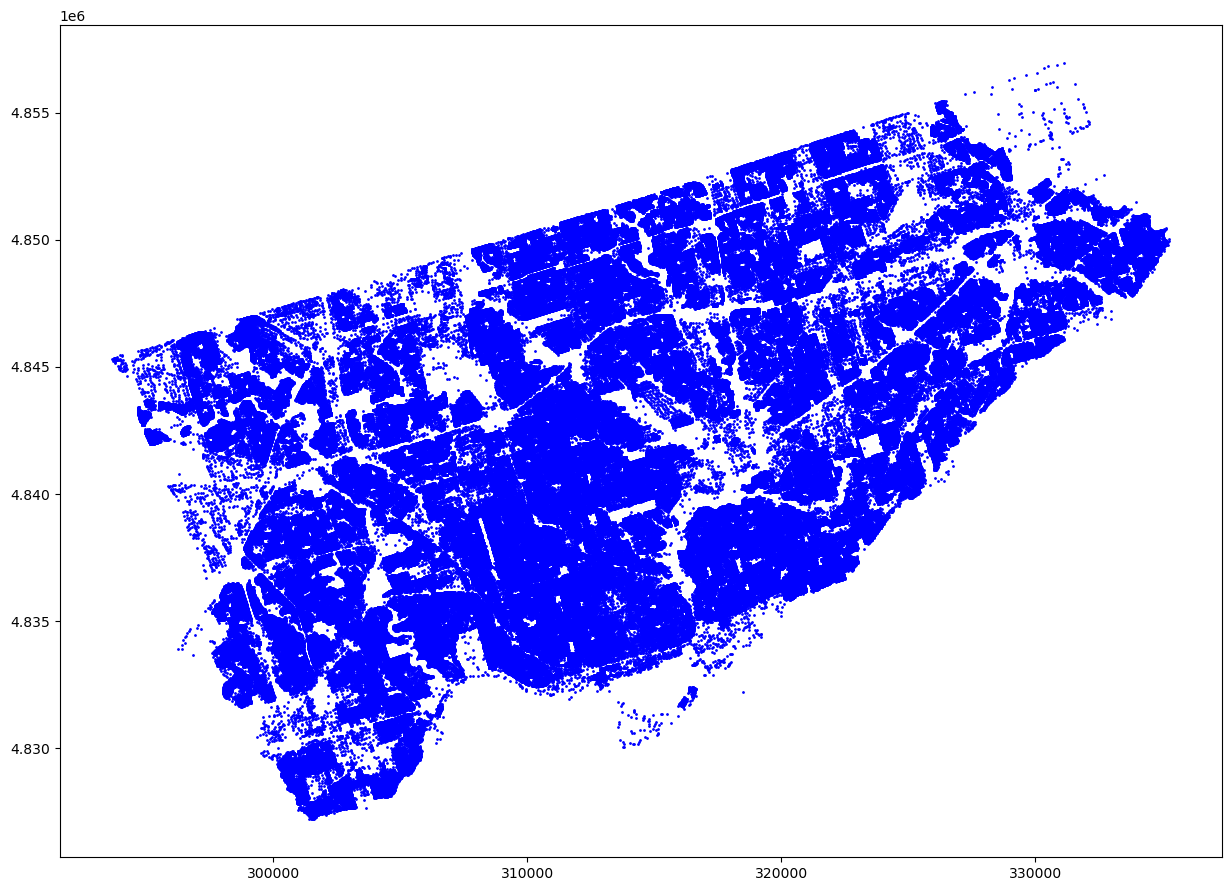

In [27]:
ax = address.plot(figsize=(15, 15),color='blue', markersize =1)

### Create a plot showing the address point data at the city block level


[(311200.0, 311800.0), (4834200.0, 4834800.0)]

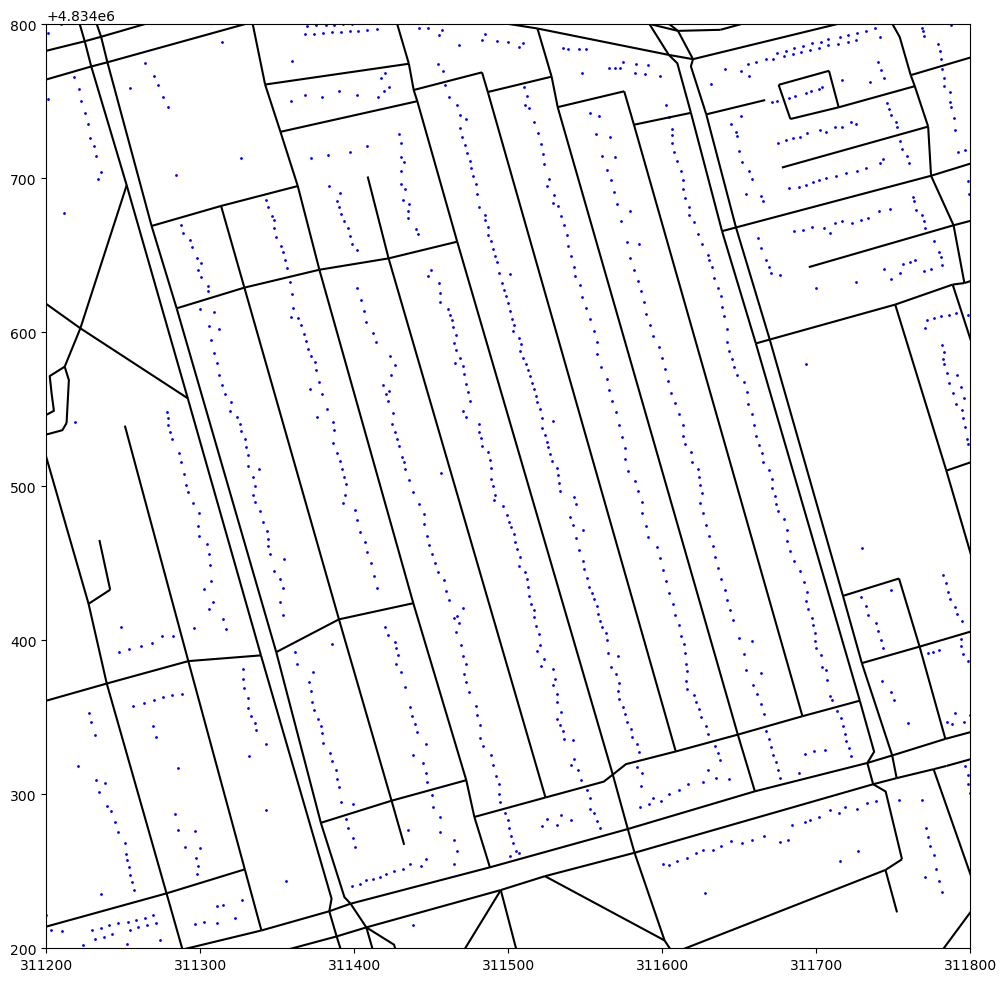

In [28]:
# plotting address layer with limits set
ax = address.plot(figsize=(12, 12),color='blue', markersize =1)
pednet.plot(ax=ax,color='black', markersize =2)
ax.set(xlim=(311200, 311800), ylim=(4834200, 4834800))

## Neighbourhood Improvement Areas
Read the Neighbourhood Improvement Areas polygon shape file and reproject to EPSG 2019

In [29]:
# reading Neighbourhood Improvement Areas polygon shape file
# https://open.toronto.ca/dataset/neighbourhood-improvement-areas/
# Go to Download Data
nia = gpd.read_file("neighbourhood-improvement-areas-wgs84.zip")
nia

AREA_ID    DATE_EFF    DATE_EXP  AREA_AT_ID  AREA_TP_ID  PARNT_AREA  \
0   25886593  2014-05-12  3000-01-01    25926665         602       49885   
1   25886723  2014-05-12  3000-01-01    25926718         602       49885   
2   25886334  2014-05-12  3000-01-01    25926719         602       49885   
3   25886704  2014-05-12  3000-01-01    25926708         602       49885   
4   25886515  2014-05-12  3000-01-01    25926709         602       49885   
5   25886994  2014-05-12  3000-01-01    25926710         602       49885   
6   25886342  2014-05-12  3000-01-01    25926716         602       49885   
7   25886613  2014-05-12  3000-01-01    25926790         602       49885   
8   25886658  2014-05-12  3000-01-01    25926791         602       49885   
9   25886693  2014-05-12  3000-01-01    25926778         602       49885   
10  25886525  2014-05-12  3000-01-01    25926793         602       49885   
11  25886640  2014-05-12  3000-01-01    25926781         602       49885   
12  25886670  2014-05-12  3000-01-01    25926722         602       49885   
13  25886480  2014-05-12  3000-01-01    25926724         602       49885   
14  25886531  2014-05-12  3000-01-01    25926797         602       49885   
15  25886737  2014-05-12  3000-01-01    25926799         602       49885   
16  25886386  2014-05-12  3000-01-01    25926796         602       49885   
17  25886380  2014-05-12  3000-01-01    25926681         602       49885   
18  25886370  2014-05-12  3000-01-01    25926746         602       49885   
19  25886548  2014-05-12  3000-01-01    25926692         602       49885   
20  25886513  2014-05-12  3000-01-01    25926773         602       49885   
21  25886733  2014-05-12  3000-01-01    25926774         602       49885   
22  25886929  2014-05-12  3000-01-01    25926701         602       49885   
23  25886870  2014-05-12  3000-01-01    25926728         602       49885   
24  25886652  2014-05-12  3000-01-01    25926769         602       49885   
25  25886607  2014-05-12  3000-01-01    25926749         602       49885   
26  25886715  2014-05-12  3000-01-01    25926682         602       49885   
27  25886473  2014-05-12  3000-01-01    25926733         602       49885   
28  25886396  2014-05-12  3000-01-01    25926703         602       49885   
29  25886362  2014-05-12  3000-01-01    25926727         602       49885   
30  25886466  2014-05-12  3000-01-01    25926679         602       49885   

   AREA_TYPE  AREA_CL_ID AREA_CL AREA_S_CD  ... FEAT_CD FEAT_C_DSC TR_ID_CRT  \
0       CNBH           0    None       027  ...       0       None    105211   
1       CNBH           0    None       003  ...       0       None    105211   
2       CNBH           0    None       055  ...       0       None    105211   
3       CNBH           0    None       028  ...       0       None    105211   
4       CNBH           0    None       139  ...       0       None    105211   
5       CNBH           0    None       085  ...       0       None    105211   
6       CNBH           0    None       061  ...       0       None    105211   
7       CNBH           0    None       021  ...       0       None    105211   
8       CNBH           0    None       022  ...       0       None    105211   
9       CNBH           0    None       044  ...       0       None    105211   
10      CNBH           0    None       125  ...       0       None    105211   
11      CNBH           0    None       025  ...       0       None    105211   
12      CNBH           0    None       043  ...       0       None    105211   
13      CNBH           0    None       136  ...       0       None    105211   
14      CNBH           0    None       124  ...       0       None    105211   
15      CNBH           0    None       006  ...       0       None    105211   
16      CNBH           0    None       110  ...       0       None    105211   
17      CNBH           0    None       115  ...       0       None    105211   
18      CNBH           0    None       112  ...     

In [30]:
# change column names from upper to lower case
nia.columns = map(str.lower, nia.columns)

#include columns needed for the project
nia = nia[['area_id','area_s_cd','area_name','geometry']]
nia

area_id area_s_cd                              area_name  \
0   25886593       027           York University Heights (27)   
1   25886723       003       Thistletown-Beaumond Heights (3)   
2   25886334       055                  Thorncliffe Park (55)   
3   25886704       028                            Rustic (28)   
4   25886515       139              Scarborough Village (139)   
5   25886994       085                    South Parkdale (85)   
6   25886342       061                     Taylor-Massey (61)   
7   25886613       021                     Humber Summit (21)   
8   25886658       022                        Humbermede (22)   
9   25886693       044                   Flemingdon Park (44)   
10  25886525       125                          Ionview (125)   
11  25886640       025            Glenfield-Jane Heights (25)   
12  25886670       043                  Victoria Village (43)   
13  25886480       136                        West Hill (136)   
14  25886531       124                     Kennedy Park (124)   
15  25886737       006      Kingsview Village-The Westway (6)   
16  25886386       110         Keelesdale-Eglinton West (110)   
17  25886380       115                     Mount Dennis (115)   
18  25886370       112          Beechborough-Greenbrook (112)   
19  25886548       121                         Oakridge (121)   
20  25886513       138                    Eglinton East (138)   
21  25886733       005                   Elms-Old Rexdale (5)   
22  25886929       072                       Regent Park (72)   
23  25886870       091                Weston-Pellam Park (91)   
24  25886652       026              Downsview-Roding-CFB (26)   
25  25886607       024                       Black Creek (24)   
26  25886715       002  Mount Olive-Silverstone-Jamestown (2)   
27  25886473       137                           Woburn (137)   
28  25886396       111                Rockcliffe-Smythe (111)   
29  25886362       113                           Weston (113)   
30  25886466       135                      Morningside (135)   

                                             geometry  
0   POLYGON ((-79.50529 43.75987, -79.50488 43.759...  
1   POLYGON ((-79.57751 43.73384, -79.57806 43.734...  
2   POLYGON ((-79.33542 43.70320, -79.33573 43.703...  
3   POLYGON ((-79.50384 43.70288, -79.50425 43.704...  
4   POLYGON ((-79.21397 43.72676, -79.21400 43.726...  
5   POLYGON ((-79.42778 43.62979, -79.42948 43.630...  
6   POLYGON ((-79.28776 43.68978, -79.29269 43.688...  
7   POLYGON ((-79.58064 43.76302, -79.57754 43.763...  
8   POLYGON ((-79.52628 43.73640, -79.52649 43.736...  
9   POLYGON ((-79.33791 43.70770, -79.33788 43.707...  
10  POLYGON ((-79.27786 43.72996, -79.27791 43.730...  
11  POLYGON ((-79.52628 43.73640, -79.52721 43.740...  
12  POLYGON ((-79.30265 43.72472, -79.30210 43.723...  
13  POLYGON ((-79.20206 43.76487, -79.20215 43.764...  
14  POLYGON ((-79.24549 43.73060, -79.24555 43.730...  
15  POLYGON ((-79.55236 43.70947, -79.55229 43.709...  
16  POLYGON ((-79.47242 43.67922, -79.47277 43.679...  
17  POLYGON ((-79.51329 43.69338, -79.51155 43.693...  
18  POLYGON ((-79.49764 43.69298, -79.49384 43.693...  
19  POLYGON ((-79.26986 43.69584, -79.27009 43.695...  
20  POLYGON ((-79.24549 43.73060, -79.24602 43.731...  
21  POLYGON ((-79.55512 43.71510, -79.55569 43.716...  
22  POLYGON ((-79.35432 43.65787, -79.35455 43.657...  
23  POLYGON ((-79.46005 43.66723, -79.46092 43.668...  
24  POLYGON ((-79.50783 43.71776, -79.50854 43.717...  
25  POLYGON ((-79.53488 43.77269, -79.53441 43.772...  
26  POLYGON ((-79.60338 43.75786, -79.60205 43.758...  
27  POLYGON ((-79.21128 43.75113, -79.21135 43.751...  
28  POLYGON ((-79.51221 43.66263, -79.51240 43.662...  
29  POLYGON ((-79.50296 43.69574, -79.50313 43.695...  
30  POLYGON ((-79.22552 43.78925, -79.22549 43.789...

In [31]:
nia.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [32]:
# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
crs = {'init': 'epsg:4326'}
nia = gpd.GeoDataFrame(nia, crs=crs, geometry='geometry')
nia = nia.to_crs({'init': 'epsg:2019'})

C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### Explore Neighbourhood Improvement Areas

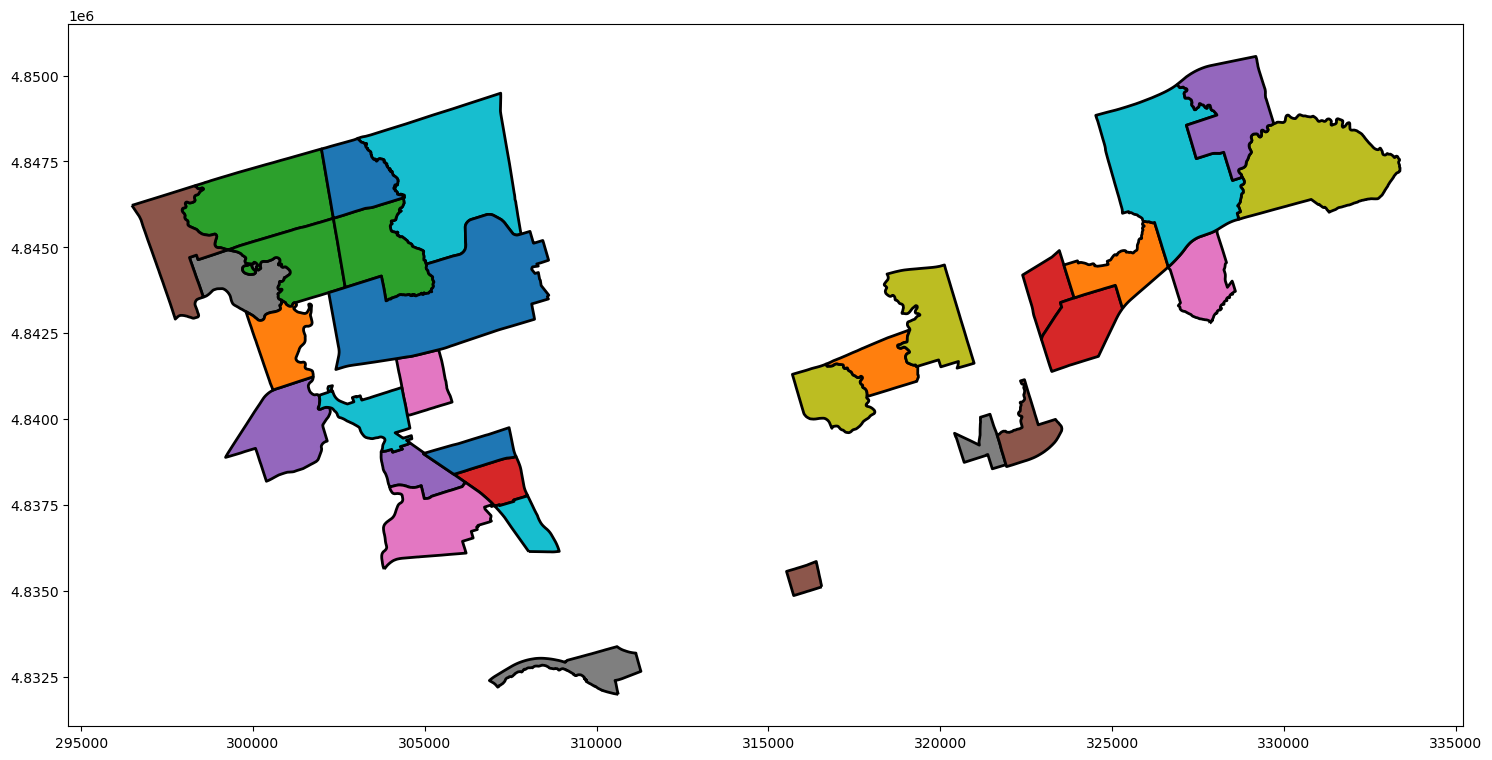

In [33]:
# plot Neighbourhood Improvement Areas
ax = nia.plot(figsize=(18, 13), column='area_name',edgecolor='black', linewidth=2)

# Step 2: Build Pandana Network
Pandana is a Python package that uses contraction hierarchies to perform rapid network calculations including shortest paths and accessibility buffers.

The link provides an introduction to the Pandana Network (https://udst.github.io/pandana/introduction.html).

## Create Network Graph Code Function

In [34]:
# creating network graph code
def create_graph(gdf, precision=3):
    '''Create a networkx given a GeoDataFrame of lines. Every line will
    correspond to two directional graph edges, one forward, one reverse. The
    original line row and direction will be stored in each edge. Every node
    will be where endpoints meet (determined by being very close together) and
    will store a clockwise ordering of incoming edges.
    '''
      
    G = nx.Graph()

    def make_node(coord, precision):
        return tuple(np.round(coord, precision))

    # Edges are stored as (from, to, data), where from and to are nodes.
    def add_edges(row, G):
        geometry = row.geometry
        coords = list(geometry.coords)
        geom_r = LineString(coords[::-1])
        coords_r = geom_r.coords
        start = make_node(coords[0], precision)
        end = make_node(coords[-1], precision)
        # Add forward edge
        fwd_attr ={}
        for k,v in row.items():
            fwd_attr[k]=v
        fwd_attr['forward']= 1
       #fwd_attr['geometry']=  geometry
        fwd_attr['length']=  geometry.length

        fwd_attr['visited']= 0

        G.add_edge(start, end, **fwd_attr)

    gdf.apply(add_edges, axis=1, args=[G])

    return G

### Create a network graph from the function above


In [35]:
# creating network graph
G = create_graph(pednet)
#from G to urbanaccess network model - one node idx,x,y one edge from to weight
#G.edges(data=True)

In [36]:
# get network "from" and "to" from nodes
edges = nx.to_pandas_edgelist(G,'from','to')
to = edges['to'].tolist()
fr = edges['from'].tolist()
fr = list(set(fr))
to = list(set(to))
to.extend(fr)
nodes = list(set(to))
nodes = pd.DataFrame(nodes)
nodes.columns=['x', 'y']
nodes['xy'] = nodes.apply(lambda z: (z.x,z.y),axis=1)

In [37]:
# Assigning node ids to to_node and from_node

nodes['id'] = nodes.index
edges['to_node']=edges['to'].map(nodes.set_index('xy').id)
edges['from_node']=edges['from'].map(nodes.set_index('xy').id)
edges

from                         to  \
0       (299647.48, 4843993.305)  (299730.645, 4843949.766)   
1       (299647.48, 4843993.305)   (299602.64, 4844063.116)   
2      (299730.645, 4843949.766)   (299811.934, 4843907.77)   
3      (299730.645, 4843949.766)  (299783.527, 4844033.238)   
4      (299319.487, 4832701.797)  (299351.915, 4832699.012)   
...                          ...                        ...   
87091  (327229.441, 4852966.294)  (327237.367, 4853015.687)   
87092  (307051.475, 4834711.445)  (307056.406, 4834694.336)   
87093  (309342.013, 4837279.095)   (309284.58, 4837260.629)   
87094  (321401.322, 4836954.751)  (321449.636, 4836949.596)   
87095   (321657.857, 4844334.23)  (321674.677, 4844314.245)   

                                                geometry  FIELD_1  FIELD_8  \
0      LINESTRING (299647.4801773648 4843993.30454792...   696841      NaN   
1      LINESTRING (299602.6398887987 4844063.11581814...   780939      NaN   
2      LINESTRING (299730.64456459746 4843949.7660014...   722552      NaN   
3      LINESTRING (299730.64456459746 4843949.7660014...   738428      NaN   
4      LINESTRING (299319.48713045556 4832701.7969447...   696842      NaN   
...                                                  ...      ...      ...   
87091  LINESTRING (327229.4406646615 4852966.29367340...   781934      NaN   
87092  LINESTRING (307051.4754708746 4834711.44545915...   781991      NaN   
87093  LINESTRING (309284.58048275416 4837260.6294444...   783712      NaN   
87094  LINESTRING (321401.32159512583 4836954.7514345...   783735      NaN   
87095  LINESTRING (321657.8566740737 4844334.22973390...   783806      NaN   

      FIELD_7 FIELD_9                        FIELD_5  FIELD_6  forward  \
0        None    None         Sidewalk on both sides        0        1   
1        None    None         Sidewalk on both sides        0        1   
2        None    None     No sidewalk on either side        0        1   
3        None    None         Sidewalk on both sides        0        1   
4        None    None         Sidewalk on both sides        0        1   
...       ...     ...                            ...      ...      ...   
87091    None    None         Sidewalk on both sides        0        1   
87092    None    None         Sidewalk on both sides        0        1   
87093    None    None  Laneway without any sidewalks        0        1   
87094    None    None  Laneway without any sidewalks        0        1   
87095    None    None     No sidewalk on either side        0        1   

       visited  FIELD_4     length         FIELD_3  to_node  from_node  
0            0        7  93.871829           Local    64150      36406  
1            0        7  82.971471           Local    25903      36406  
2            0        3  91.496355           Local    39647      64150  
3            0        7  98.813743           Local    49430      64150  
4            0        7  32.547298       Collector    21177      43712  
...        ...      ...        ...             ...      ...        ...  
87091        0        7  50.025415  Minor Arterial    20725      21457  
87092        0        7  17.805959           Local    46428       1087  
87093        0       10  60.328226         Laneway    60133      16828  
87094        0       10  48.588611         Laneway    59081       8076  
87095        0        3  26.121263           Local    47877      34422  

[87096 rows x 16 columns]

### Creating and Saving Pandana Network
Create the Pandana Network and save the file in case you lose the network in memory

In [38]:
# creating pandana network

transit_ped_net = pdna.Network(nodes["x"],
                               nodes["y"],
                               edges["from_node"],
                               edges["to_node"],
                               pd.DataFrame([edges['length']]).T,
                               twoway=True)

# saving walkability file is optional. It can be used in the next steps if you don't have transit_ped_net in memory
transit_ped_net.save_hdf5('./walkability.hd5')

### Reading Pandana Network file
This step is only required if you do not already have transit_ped_net in memory

In [39]:
transit_ped_net = pdna.Network.from_hdf5('walkability.hd5')

### Precompute a Horizon Distance
It’s probably a good idea to precompute a given horizon distance so that aggregations don’t perform the network queries unnecessarily. This is done by calling the following code, where 1000 meters is used as the horizon distance:

In [40]:
#precompute a given horizon distance of 1000 meters
transit_ped_net.precompute(1000)
transit_ped_net.edges_df

from     to     length
0      36406  64150  93.871829
1      36406  25903  82.971471
2      64150  39647  91.496355
3      64150  49430  98.813743
4      43712  21177  32.547298
...      ...    ...        ...
87091  21457  20725  50.025415
87092   1087  46428  17.805959
87093  16828  60133  60.328226
87094   8076  59081  48.588611
87095  34422  47877  26.121263

[87096 rows x 3 columns]

#### Get the nearest pednet intersection node ids for each point from the address and CCC layers

In [41]:
#get node_ids for points for each layer
x, y = ccc.x, ccc.y
ccc["node_ids"] = transit_ped_net.get_node_ids(x, y)
transit_ped_net.set(ccc["node_ids"], name="ccc")

# using x and y coordinates from address that are utm nad27 
x, y = address.x, address.y
address["node_ids"] = transit_ped_net.get_node_ids(x, y)

#### Get 10 nearest CCC points
The 10 nearest CCCs will be determined.

In [42]:
#get nearest points with id
n=10
maxdistance = 5000

transit_ped_net.set_pois("ccc", maxdistance , n, ccc.x, ccc.y)
ccc_walk_distances = transit_ped_net.nearest_pois(maxdistance , "ccc", num_pois=n, include_poi_ids=False)

ccc_walk_distances

1            2            3            4            5   \
0       117.717003   194.886993   831.758972   831.758972   997.656982   
1         0.000000   596.903015   936.593994  1059.620972  1092.590942   
2      1245.493042  1551.692017  1734.816040  1751.748047  1955.875977   
3       487.529999   528.705017   548.679993   601.640015   801.276001   
4       543.125000   543.125000   611.471008   666.297974   808.945984   
...            ...          ...          ...          ...          ...   
64710   404.274994   485.333008   494.292999   499.760986   764.426025   
64711   254.727997   621.460999   642.802979   856.921997   973.551025   
64712  1092.463989  1592.456055  2099.543945  2227.733887  2253.731934   
64713   769.059998  1141.704956  1183.921997  1513.063965  1537.572998   
64714  1046.261963  1064.229980  1181.598999  1261.635010  1349.668945   

                6            7            8            9            10  
0      1037.240967  1216.671997  1229.557983  1396.671997  1411.958008  
1      1097.404053  1247.916016  1504.416992  1700.845947  1700.845947  
2      2004.718994  2043.421021  2058.321045  2084.980957  2205.486084  
3       838.419006   877.505981  1511.416992  1574.488037  1616.719971  
4      1229.531982  1443.529053  1443.529053  1794.136963  1881.416016  
...            ...          ...          ...          ...          ...  
64710   902.218994  1009.200012  1058.219971  1124.661011  1125.817993  
64711  1076.338989  1293.927002  1410.869019  1515.651001  1624.531982  
64712  2306.155029  2328.667969  2393.108887  2678.379883  2699.750977  
64713  1539.066040  1578.115967  1604.527954  1674.900024  1970.708984  
64714  1536.770020  1555.286987  1587.494995  1671.667969  1685.758057  

[64715 rows x 10 columns]

#### Renaming columns

In [43]:
# Rename columns 1 to 10 to d_ttcstop_0 to d_ttcstop_9.

n=10

columns =  ['d_ttcstop_'+str(i) for i in range(0,n,1)]

ccc_walk_distances.columns = columns
ccc_walk_distances

d_ttcstop_0  d_ttcstop_1  d_ttcstop_2  d_ttcstop_3  d_ttcstop_4  \
0       117.717003   194.886993   831.758972   831.758972   997.656982   
1         0.000000   596.903015   936.593994  1059.620972  1092.590942   
2      1245.493042  1551.692017  1734.816040  1751.748047  1955.875977   
3       487.529999   528.705017   548.679993   601.640015   801.276001   
4       543.125000   543.125000   611.471008   666.297974   808.945984   
...            ...          ...          ...          ...          ...   
64710   404.274994   485.333008   494.292999   499.760986   764.426025   
64711   254.727997   621.460999   642.802979   856.921997   973.551025   
64712  1092.463989  1592.456055  2099.543945  2227.733887  2253.731934   
64713   769.059998  1141.704956  1183.921997  1513.063965  1537.572998   
64714  1046.261963  1064.229980  1181.598999  1261.635010  1349.668945   

       d_ttcstop_5  d_ttcstop_6  d_ttcstop_7  d_ttcstop_8  d_ttcstop_9  
0      1037.240967  1216.671997  1229.557983  1396.671997  1411.958008  
1      1097.404053  1247.916016  1504.416992  1700.845947  1700.845947  
2      2004.718994  2043.421021  2058.321045  2084.980957  2205.486084  
3       838.419006   877.505981  1511.416992  1574.488037  1616.719971  
4      1229.531982  1443.529053  1443.529053  1794.136963  1881.416016  
...            ...          ...          ...          ...          ...  
64710   902.218994  1009.200012  1058.219971  1124.661011  1125.817993  
64711  1076.338989  1293.927002  1410.869019  1515.651001  1624.531982  
64712  2306.155029  2328.667969  2393.108887  2678.379883  2699.750977  
64713  1539.066040  1578.115967  1604.527954  1674.900024  1970.708984  
64714  1536.770020  1555.286987  1587.494995  1671.667969  1685.758057  

[64715 rows x 10 columns]

#### Calculating walk distance from address points to cccs and get each point id from CCC.


In [44]:
for i in range(10):
    address['d_ttcstop_{}'.format(i)]=address['node_ids'].map(ccc_walk_distances['d_ttcstop_{}'.format(i)])
address

geo_id maint_stag address            lfname           x  \
0        5729529    REGULAR     399    Lake Promenade  301607.151   
1        9950585    REGULAR       7           Hilo Rd  301540.011   
2        5729496    REGULAR     387    Lake Promenade  301648.488   
3        5729341    REGULAR     321    Lake Promenade  301926.249   
4        7304577    REGULAR      22   Thirty Sixth St  301937.384   
...          ...        ...     ...               ...         ...   
525470  30090978    REGULAR     935    Eglinton Ave W  310615.385   
525471  30098425    REGULAR     180  Fairview Mall Dr  317534.188   
525472  30098430    REGULAR      17    Allenbury Gdns  317491.442   
525473  30112831    REGULAR     188  Fairview Mall Dr  317563.408   
525474  30107192    REGULAR     43B           Park St  324486.414   

                  y  longitude   latitude  objectid     mun_name  ...  \
0       4827443.931 -79.539542  43.586930   1491585    Etobicoke  ...   
1       4827592.989 -79.540374  43.588272   1491586    Etobicoke  ...   
2       4827472.065 -79.539030  43.587184   1491591    Etobicoke  ...   
3       4827620.088 -79.535591  43.588517   1491594    Etobicoke  ...   
4       4827737.920 -79.535454  43.589578   1491597    Etobicoke  ...   
...             ...        ...        ...       ...          ...  ...   
525470  4840045.680 -79.427849  43.700339   4611196         York  ...   
525471  4848943.535 -79.341798  43.780343   4613003   North York  ...   
525472  4848985.955 -79.342329  43.780726   4613012   North York  ...   
525473  4848985.222 -79.341434  43.780718   4613018   North York  ...   
525474  4841160.336 -79.255714  43.710134   4614642  Scarborough  ...   

       d_ttcstop_0 d_ttcstop_1  d_ttcstop_2  d_ttcstop_3  d_ttcstop_4  \
0       525.765991  805.987976  1215.489014  1518.217041  1788.779053   
1       414.541992  615.520020  1025.020996  1327.749023  1598.311035   
2       525.765991  805.987976  1215.489014  1518.217041  1788.779053   
3       555.085999  783.262024   911.354004  1021.333008  1360.338989   
4       372.287994  601.028015   838.534973   906.736023  1177.541016   
...            ...         ...          ...          ...          ...   
525470  271.770996  475.730011   479.162994   650.760010   663.799988   
525471  448.500000  916.786987  1373.395020  1410.411011  1450.239990   
525472  521.468018  953.213013  1133.901978  1317.213989  1354.229980   
525473  509.807007  978.093994  1312.088013  1349.104004  1388.932983   
525474  587.546997  895.559021   949.731018  1399.562012  1470.489014   

        d_ttcstop_5  d_ttcstop_6  d_ttcstop_7  d_ttcstop_8  d_ttcstop_9  
0       1888.009033  2183.667969  2301.128906  2309.674072  2394.002930  
1       1697.541016  1993.199951  2110.660889  2119.206055  2203.534912  
2       1888.009033  2183.667969  2301.128906  2309.674072  2394.002930  
3       1853.328979  1946.203003  1973.925049  2098.965088  2269.583984  
4       1689.890991  1782.765015  1791.126953  1935.563965  2086.785889  
...             ...          ...          ...          ...          ...  
525470   938.452026  1093.595947  1097.713989  1107.887939  1110.229980  
525471  1462.567017  1510.443970  1512.285034  1539.043945  1569.791992  
525472  1427.244995  1498.993042  1505.604980  1546.869995  1575.469971  
525473  1450.978027  1523.874023  1542.590942  1571.750977  1600.350952  
525474  1950.541016  1990.686035  2172.540039  2207.041016  2253.836914  

[525475 rows x 23 columns]

#### Calculate minutes fields based on distances
We are applying an average pedestrian walking speed of 1.2 m/s which is used by the City of Toronto Transportation Services uses.The link below is to the TRANSPORTATION SERVICES STANDARD OPERATING PRACTICE - TRAFFIC SYSTEMS OPERATIONS document which discusses the standardized walk speed of 1.2 m/s.

https://www.toronto.ca/wp-content/uploads/2019/01/96a8-TS_Traffic-Management_Pedestrian-Timing-Guidelines.pdf

In [45]:
# Calculate minutes fields based on distances. This cell takes 1.5 minutes to run.

address['m_ttcstop_0'] = address.apply(lambda row: row.d_ttcstop_0/(1.2*60), axis=1)
address['m_ttcstop_1'] = address.apply(lambda row: row.d_ttcstop_1/(1.2*60), axis=1)
address['m_ttcstop_2'] = address.apply(lambda row: row.d_ttcstop_2/(1.2*60), axis=1)
address['m_ttcstop_3'] = address.apply(lambda row: row.d_ttcstop_3/(1.2*60), axis=1)
address['m_ttcstop_4'] = address.apply(lambda row: row.d_ttcstop_4/(1.2*60), axis=1)
address['m_ttcstop_5'] = address.apply(lambda row: row.d_ttcstop_5/(1.2*60), axis=1)
address['m_ttcstop_6'] = address.apply(lambda row: row.d_ttcstop_6/(1.2*60), axis=1)
address['m_ttcstop_7'] = address.apply(lambda row: row.d_ttcstop_7/(1.2*60), axis=1)
address['m_ttcstop_8'] = address.apply(lambda row: row.d_ttcstop_8/(1.2*60), axis=1)
address['m_ttcstop_9'] = address.apply(lambda row: row.d_ttcstop_9/(1.2*60), axis=1)
address

geo_id maint_stag address            lfname           x  \
0        5729529    REGULAR     399    Lake Promenade  301607.151   
1        9950585    REGULAR       7           Hilo Rd  301540.011   
2        5729496    REGULAR     387    Lake Promenade  301648.488   
3        5729341    REGULAR     321    Lake Promenade  301926.249   
4        7304577    REGULAR      22   Thirty Sixth St  301937.384   
...          ...        ...     ...               ...         ...   
525470  30090978    REGULAR     935    Eglinton Ave W  310615.385   
525471  30098425    REGULAR     180  Fairview Mall Dr  317534.188   
525472  30098430    REGULAR      17    Allenbury Gdns  317491.442   
525473  30112831    REGULAR     188  Fairview Mall Dr  317563.408   
525474  30107192    REGULAR     43B           Park St  324486.414   

                  y  longitude   latitude  objectid     mun_name  ...  \
0       4827443.931 -79.539542  43.586930   1491585    Etobicoke  ...   
1       4827592.989 -79.540374  43.588272   1491586    Etobicoke  ...   
2       4827472.065 -79.539030  43.587184   1491591    Etobicoke  ...   
3       4827620.088 -79.535591  43.588517   1491594    Etobicoke  ...   
4       4827737.920 -79.535454  43.589578   1491597    Etobicoke  ...   
...             ...        ...        ...       ...          ...  ...   
525470  4840045.680 -79.427849  43.700339   4611196         York  ...   
525471  4848943.535 -79.341798  43.780343   4613003   North York  ...   
525472  4848985.955 -79.342329  43.780726   4613012   North York  ...   
525473  4848985.222 -79.341434  43.780718   4613018   North York  ...   
525474  4841160.336 -79.255714  43.710134   4614642  Scarborough  ...   

       m_ttcstop_0 m_ttcstop_1  m_ttcstop_2  m_ttcstop_3  m_ttcstop_4  \
0         7.302305   11.194277    16.881792    21.086348    24.844154   
1         5.757528    8.548889    14.236403    18.440959    22.198764   
2         7.302305   11.194277    16.881792    21.086348    24.844154   
3         7.709528   10.878639    12.657694    14.185181    18.893597   
4         5.170667    8.347611    11.646319    12.593556    16.354736   
...            ...         ...          ...          ...          ...   
525470    3.774597    6.607361     6.655042     9.038333     9.219444   
525471    6.229167   12.733153    19.074931    19.589042    20.142222   
525472    7.242611   13.239070    15.748639    18.294639    18.808750   
525473    7.080653   13.584639    18.223445    18.737556    19.290736   
525474    8.160375   12.438320    13.190709    19.438361    20.423459   

        m_ttcstop_5  m_ttcstop_6  m_ttcstop_7  m_ttcstop_8  m_ttcstop_9  
0         26.222348    30.328722    31.960124    32.078807    33.250041  
1         23.576959    27.683333    29.314735    29.433417    30.604652  
2         26.222348    30.328722    31.960124    32.078807    33.250041  
3         25.740680    27.030597    27.415626    29.152293    31.522000  
4         23.470708    24.760625    24.876763    26.882833    28.983137  
...             ...          ...          ...          ...          ...  
525470    13.034056    15.188833    15.246028    15.387332    15.419861  
525471    20.313431    20.978388    21.003959    21.375610    21.802667  
525472    19.822847    20.819348    20.911180    21.484305    21.881527  
525473    20.152473    21.164917    21.424874    21.829875    22.227097  
525474    27.090847    27.648417    30.174167    30.653347    31.303290  

[525475 rows x 33 columns]

# Step 3: Visualize Walking Times
In this step we will create a series of visulations illustrating the walking times to the nearest CCC across the pedestrian network.

## Walking Times To Closest CCC
In this section we will create a chloropleth map showing the walk times to the closest CCC across the City of Toronto. As expected the shortest walk times are along majorial aerterials where CCCs are located as shown in the second map below where the CCCs are colour coded red.

Text(0.5, 1.0, 'Walking Times To Closest TTC Stop')

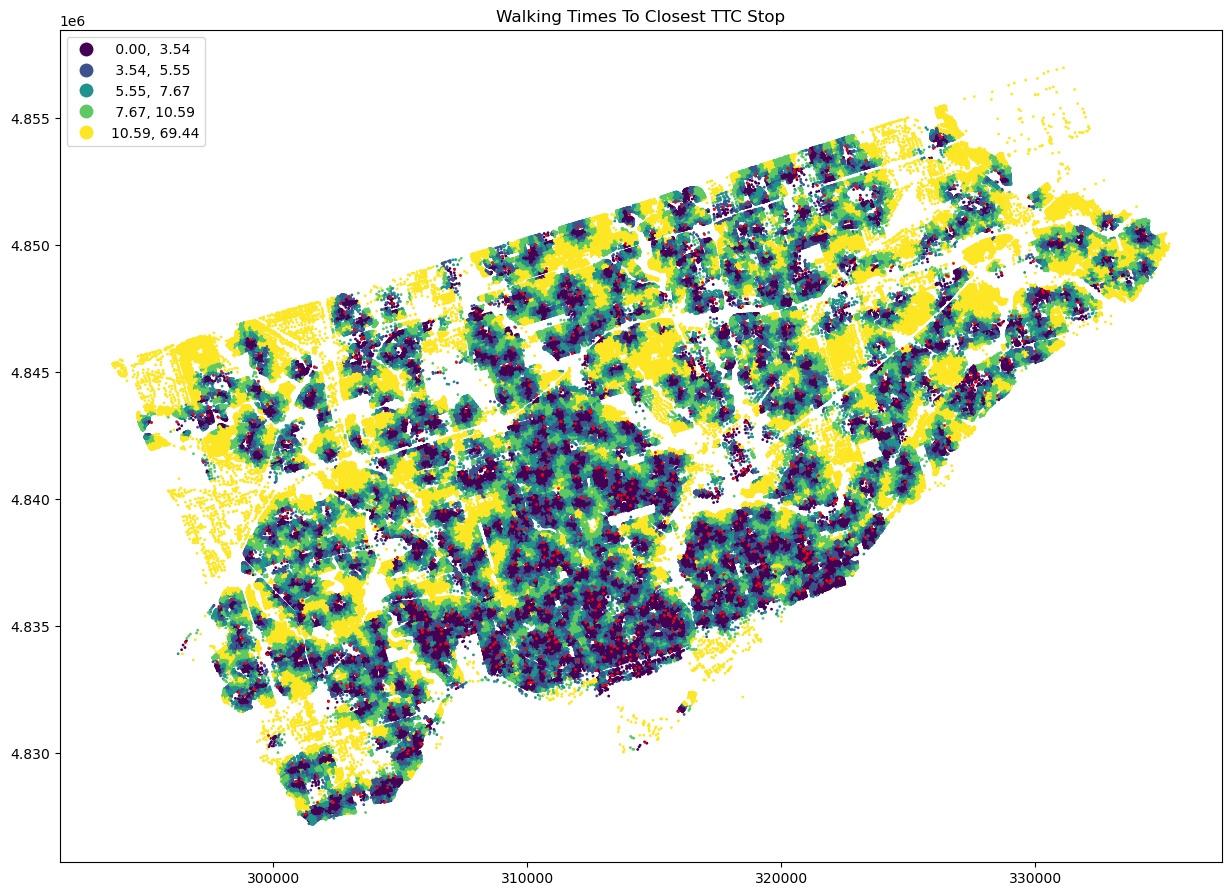

In [46]:
# Walking times To closest CCC with CCCs added
import mapclassify
ax = address.plot(figsize=(15, 15), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 1)
ccc.plot(ax=ax, color='red', markersize =1)
plt.title('Walking Times To Closest CCC')

## Walking Times To Closest CCC with Neighbourhood Improvement Areas

In this step we will invesitgate the walk times in the Neighbourhood Improvement Areas.

## Get the Neighbourhood Improvement Area centre points

To place a label on each Neighbourhood Improvement Areas in the plot we need to find an identifiable point which exists within each polygon so that we can say where we want the text to be placed.

In [47]:
# Here we find the center points, copy our original df to a new df, and then set
# the geometry column to the newly created center points column
# (because a GeoPandas df can only have one geometry column)
nia["center"] = nia["geometry"].centroid
nia_points = nia.copy()
nia_points.set_geometry("center", inplace = True)

Text(0.5, 1.0, 'Walking Times To Closest TTC Stop \n within Neighbourhood Improvement Areas')

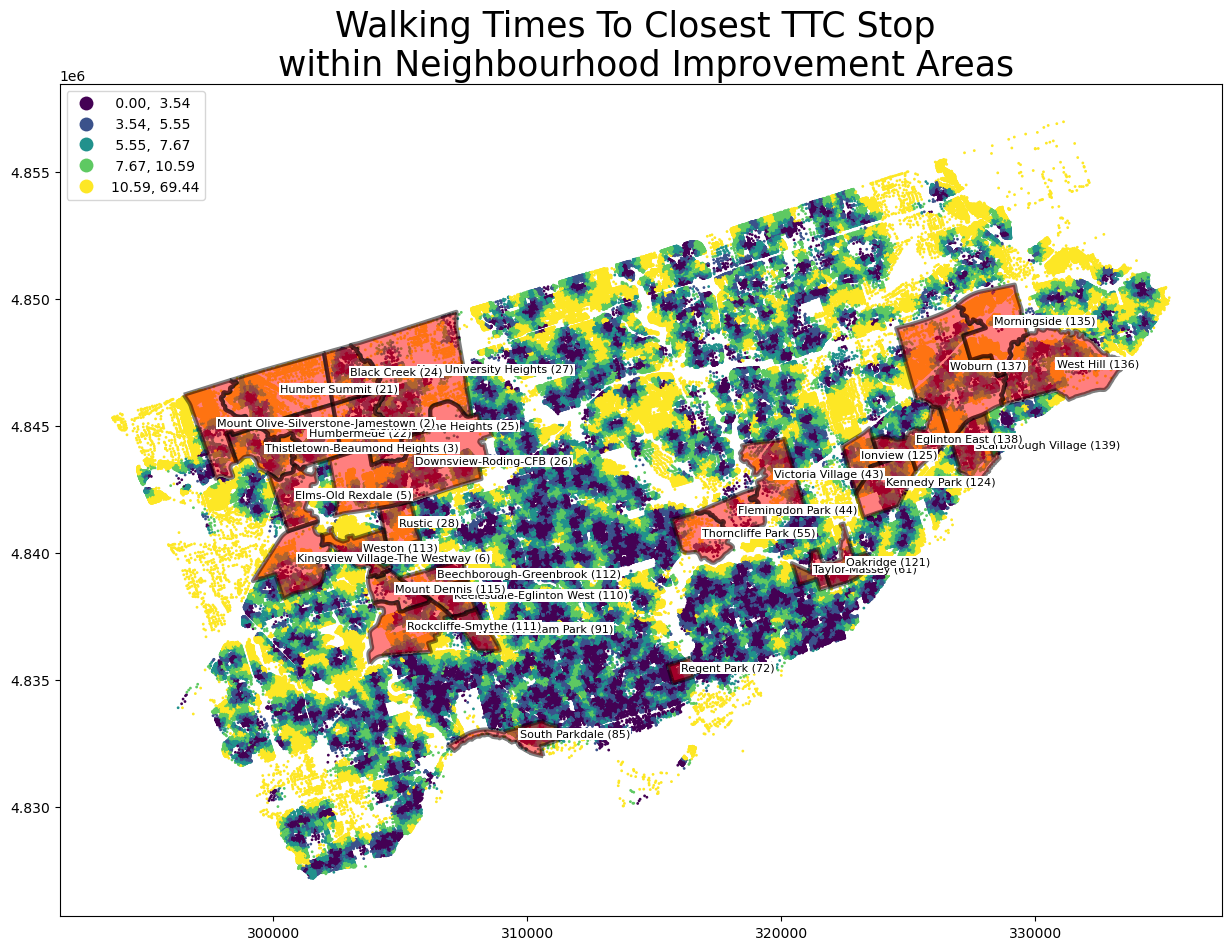

In [48]:
# ploting and adding labels for Neighbourhood Improvement Areas
ax = address.plot(figsize=(15, 15), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 1)
nia.plot(ax=ax, edgecolor='black', facecolor='red', linewidth=3, alpha=.5 )
texts = []

# Plot labels and add a white box behind the label using the matplotlib bbox class.
for x, y, label in zip(nia_points.geometry.x, nia_points.geometry.y, nia_points["area_name"]):
    texts.append(plt.text(x, y, label, fontsize = 8, bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none')))

ax.set_title('Walking Times To Closest CCC \n within Neighbourhood Improvement Areas', fontdict={'fontsize': '25', 'fontweight' : '3'})

#plt.savefig("./walkability_nia.png", dpi=300)

# Addresses within Neighbourhood Improvement Areas

We will now perform a spatial join between Neighbourhood Improvement Area layer and address layer in order to allocate addresses to Neighbourhood Improvement Areas.

In [49]:
# Spatial Join where Neighbourhood Improvement Area polygons are intersected with address points
nia_address = gpd.sjoin(nia, address, op='intersects', how='left')
nia_address

C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\IPython\core\interactiveshell.py:3472: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


area_id area_s_cd                     area_name  \
0   25886593       027  York University Heights (27)   
0   25886593       027  York University Heights (27)   
0   25886593       027  York University Heights (27)   
0   25886593       027  York University Heights (27)   
0   25886593       027  York University Heights (27)   
..       ...       ...                           ...   
30  25886466       135             Morningside (135)   
30  25886466       135             Morningside (135)   
30  25886466       135             Morningside (135)   
30  25886466       135             Morningside (135)   
30  25886466       135             Morningside (135)   

                                             geometry  \
0   POLYGON ((304374.200 4846441.251, 304406.841 4...   
0   POLYGON ((304374.200 4846441.251, 304406.841 4...   
0   POLYGON ((304374.200 4846441.251, 304406.841 4...   
0   POLYGON ((304374.200 4846441.251, 304406.841 4...   
0   POLYGON ((304374.200 4846441.251, 304406.841 4...   
..                                                ...   
30  POLYGON ((326891.120 4849741.351, 326893.887 4...   
30  POLYGON ((326891.120 4849741.351, 326893.887 4...   
30  POLYGON ((326891.120 4849741.351, 326893.887 4...   
30  POLYGON ((326891.120 4849741.351, 326893.887 4...   
30  POLYGON ((326891.120 4849741.351, 326893.887 4...   

                            center  index_right    geo_id maint_stag  address  \
0   POINT (305695.095 4847092.650)       501365   8594884    REGULAR      907   
0   POINT (305695.095 4847092.650)       501372   8594885    REGULAR  909-911   
0   POINT (305695.095 4847092.650)       501369   8594886    REGULAR      913   
0   POINT (305695.095 4847092.650)       501370   8594887    REGULAR  915-917   
0   POINT (305695.095 4847092.650)       501364   8594888    REGULAR      919   
..                             ...          ...       ...        ...      ...   
30  POINT (328381.142 4848985.391)       461893    369560    REGULAR       29   
30  POINT (328381.142 4848985.391)       461262    369562    REGULAR       31   
30  POINT (328381.142 4848985.391)       460247    353175    REGULAR        1   
30  POINT (328381.142 4848985.391)       461900    354524    REGULAR     3930   
30  POINT (328381.142 4848985.391)       461608  13366887    REGULAR     3950   

            lfname  ...  m_ttcstop_0  m_ttcstop_1  m_ttcstop_2  m_ttcstop_3  \
0        Alness St  ...     9.329444    15.248098    34.411126    34.799418   
0        Alness St  ...     9.329444    15.248098    34.411126    34.799418   
0        Alness St  ...     9.329444    15.248098    34.411126    34.799418   
0        Alness St  ...     9.329444    15.248098    34.411126    34.799418   
0        Alness St  ...     9.329444    15.248098    34.411126    34.799418   
..             ...  ...          ...          ...          ...          ...   
30   Orton Park Rd  ...     8.888764     9.594500    11.439208    14.011152   
30   Orton Park Rd  ...     8.888764     9.594500    11.439208    14.011152   
30  Ladysbridge Dr  ...     8.888764     9.594500    11.439208    14.011152   
30  Lawrence Ave E  ...     5.937472     6.643208     8.487917    11.059861   
30  Lawrence Ave E  ...     7.110847     7.816583     9.661291    12.233237   

    m_ttcstop_4 m_ttcstop_5 m_ttcstop_6  m_ttcstop_7  m_ttcstop_8  m_ttcstop_9  
0     38.023485   40.610752   42.004751    43.426124    44.902361    45.210585  
0     38.023485   40.610752   42.004751    43.426124    44.902361    45.210585  
0     38.023485   40.610752   42.004751    43.426124    44.902361    45.210585  
0     38.023485   40.610752   42.004751    43.426124    44.902361    45.210585  
0     38.023485   40.610752   42.004751    43.426124    44.902361    45.210585  
..          ...         ...         ...          ...          ...          ...  
30    19.847417   22.012431   24.114917    26.494181    27.181390    31.024499  
30    19.847417   22.012431   24.114917    26.494181    27.181390    31.02449

# Count of addresses in Neighbourhood Improvement Areas

We will now do a count of addresses within each Neighbourhood Improvement Areas and visualize the results in a bar plot.

In [50]:
# count of addresses assigned to each Neighbourhood Improvement Area
value_counts = nia_address.area_name.value_counts()
value_counts

Woburn (137)                             8469
Downsview-Roding-CFB (26)                7789
West Hill (136)                          5346
Rockcliffe-Smythe (111)                  5133
Glenfield-Jane Heights (25)              4818
York University Heights (27)             4439
Humber Summit (21)                       3791
Weston-Pellam Park (91)                  3420
Keelesdale-Eglinton West (110)           3123
Kennedy Park (124)                       3037
Weston (113)                             3034
Morningside (135)                        2946
Kingsview Village-The Westway (6)        2797
Mount Olive-Silverstone-Jamestown (2)    2772
Humbermede (22)                          2623
Thistletown-Beaumond Heights (3)         2483
Eglinton East (138)                      2423
Victoria Village (43)                    2337
Oakridge (121)                           2153
Mount Dennis (115)                       1971
Black Creek (24)                         1954
Ionview (125)                     

In [51]:
# count of addresses assigned to each Neighbourhood Improvement Area
value_counts = nia_address.area_name.value_counts()
value_counts

# renaming axixs to area_name and resetting index to nia_address_count
nia_address_counts = value_counts.rename_axis('area_name').reset_index(name='nia_address_count')
nia_address_counts

# merge nia_address_counts with nia_address using the area_name which is shared by both dataframes
nia_address = pd.merge(nia_address, nia_address_counts)

nia_address

area_id area_s_cd                     area_name  \
0      25886593       027  York University Heights (27)   
1      25886593       027  York University Heights (27)   
2      25886593       027  York University Heights (27)   
3      25886593       027  York University Heights (27)   
4      25886593       027  York University Heights (27)   
...         ...       ...                           ...   
89720  25886466       135             Morningside (135)   
89721  25886466       135             Morningside (135)   
89722  25886466       135             Morningside (135)   
89723  25886466       135             Morningside (135)   
89724  25886466       135             Morningside (135)   

                                                geometry  \
0      POLYGON ((304374.200 4846441.251, 304406.841 4...   
1      POLYGON ((304374.200 4846441.251, 304406.841 4...   
2      POLYGON ((304374.200 4846441.251, 304406.841 4...   
3      POLYGON ((304374.200 4846441.251, 304406.841 4...   
4      POLYGON ((304374.200 4846441.251, 304406.841 4...   
...                                                  ...   
89720  POLYGON ((326891.120 4849741.351, 326893.887 4...   
89721  POLYGON ((326891.120 4849741.351, 326893.887 4...   
89722  POLYGON ((326891.120 4849741.351, 326893.887 4...   
89723  POLYGON ((326891.120 4849741.351, 326893.887 4...   
89724  POLYGON ((326891.120 4849741.351, 326893.887 4...   

                               center  index_right    geo_id maint_stag  \
0      POINT (305695.095 4847092.650)       501365   8594884    REGULAR   
1      POINT (305695.095 4847092.650)       501372   8594885    REGULAR   
2      POINT (305695.095 4847092.650)       501369   8594886    REGULAR   
3      POINT (305695.095 4847092.650)       501370   8594887    REGULAR   
4      POINT (305695.095 4847092.650)       501364   8594888    REGULAR   
...                               ...          ...       ...        ...   
89720  POINT (328381.142 4848985.391)       461893    369560    REGULAR   
89721  POINT (328381.142 4848985.391)       461262    369562    REGULAR   
89722  POINT (328381.142 4848985.391)       460247    353175    REGULAR   
89723  POINT (328381.142 4848985.391)       461900    354524    REGULAR   
89724  POINT (328381.142 4848985.391)       461608  13366887    REGULAR   

       address          lfname  ...  m_ttcstop_1  m_ttcstop_2  m_ttcstop_3  \
0          907       Alness St  ...    15.248098    34.411126    34.799418   
1      909-911       Alness St  ...    15.248098    34.411126    34.799418   
2          913       Alness St  ...    15.248098    34.411126    34.799418   
3      915-917       Alness St  ...    15.248098    34.411126    34.799418   
4          919       Alness St  ...    15.248098    34.411126    34.799418   
...        ...             ...  ...          ...          ...          ...   
89720       29   Orton Park Rd  ...     9.594500    11.439208    14.011152   
89721       31   Orton Park Rd  ...     9.594500    11.439208    14.011152   
89722        1  Ladysbridge Dr  ...     9.594500    11.439208    14.011152   
89723     3930  Lawrence Ave E  ...     6.643208     8.487917    11.059861   
89724     3950  Lawrence Ave E  ...     7.816583     9.661291    12.233237   

       m_ttcstop_4  m_ttcstop_5 m_ttcstop_6 m_ttcstop_7  m_ttcstop_8  \
0        38.023485    40.610752   42.004751   43.426124    44.902361   
1        38.023485    40.610752   42.004751   43.426124    44.902361   
2        38.023485    40.610752   42.004751   43.426124    44.902361   
3        38.023485    40.610752   42.004751   43.426124    44.902361   
4        38.023485    40.610752   42.004751   43.426124    44.902361   
...            ...          ...         ...         ...          ...   
89720    19.847417    22.012431   24.114917   26.494181    27.181390   
89721    19.847417    22.012431   24.114917   26.494181    27.181390   
89722    19.847417    22.012431   24.114917   26.494181    27.181390   
89723    16.896125  

<AxesSubplot:title={'center':'Address Count in Neighbourhood Improvement Areas'}, xlabel='Neighbourhood Improvement Areas', ylabel='Number'>

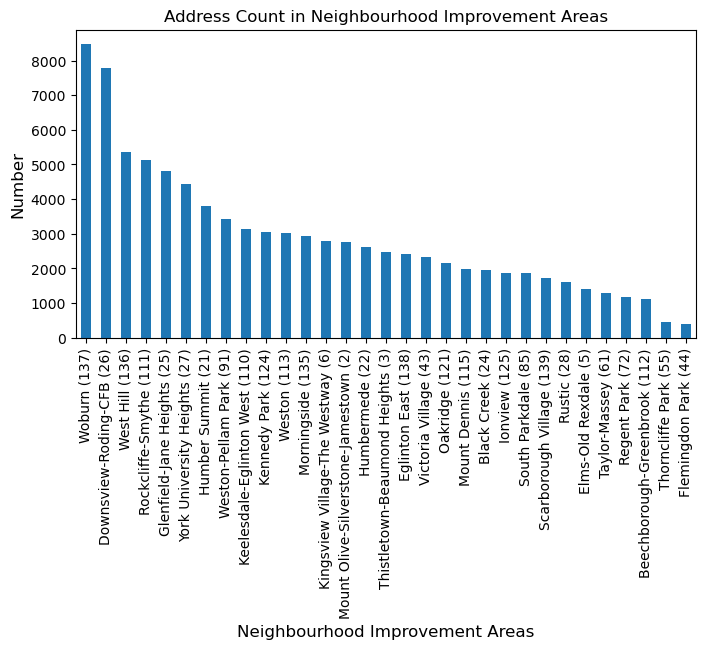

In [52]:
# distribution of addresses in nia_address

#plot
plt.figure(figsize=(8,4))

plt.title("Address Count in Neighbourhood Improvement Areas")
plt.ylabel('Number', fontsize=12)
plt.xlabel('Neighbourhood Improvement Areas', fontsize=12)

nia_address.area_name.value_counts().plot.bar()

Text(0.5, 1.0, 'Walking Times To Closest TTC Stop')

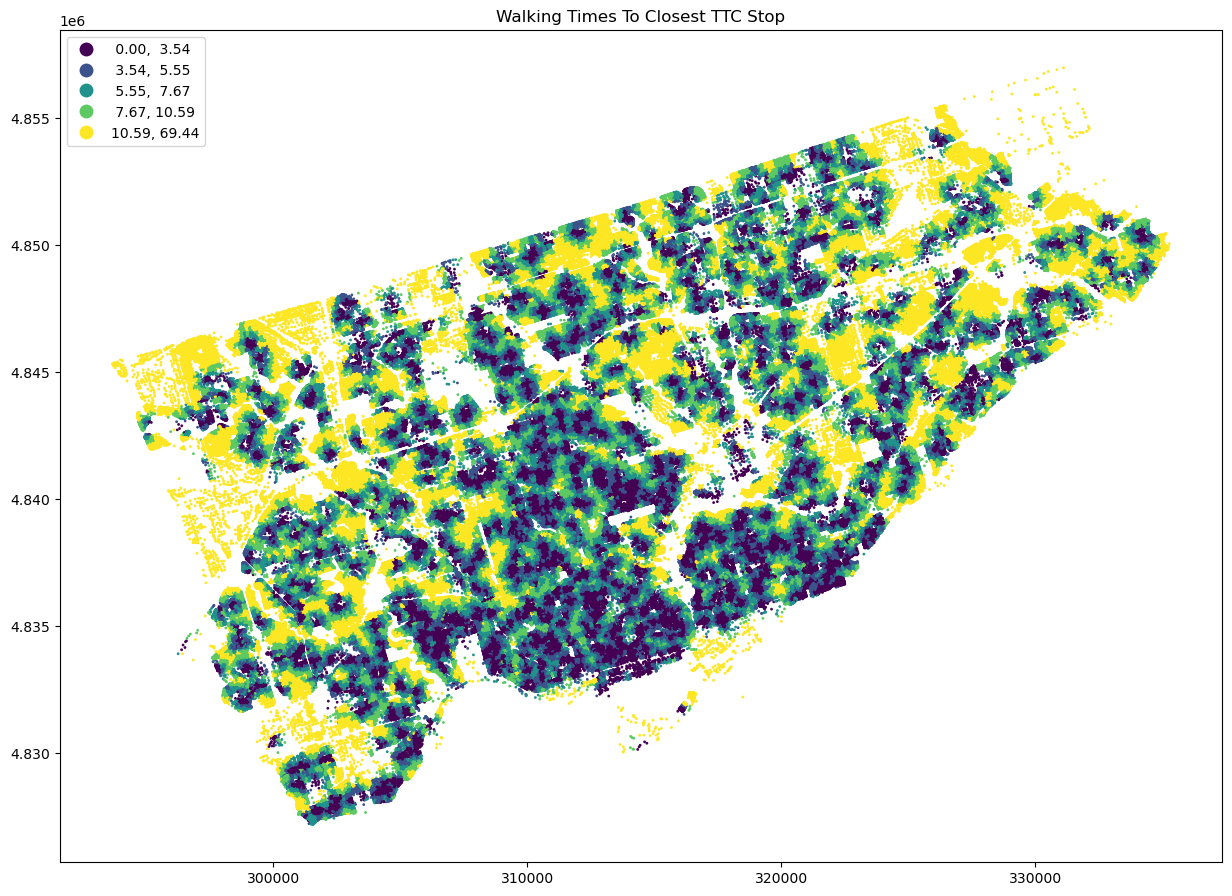

In [53]:
# Walking Times To Closest CCC
ax = address.plot(figsize=(15, 15), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 1)
plt.title('Walking Times To Closest CCC')

# Average Walking Times To Closest CCC in Neighbourhood Improvement Areas

We will now use the mean function to calculate the mean walking time to the closest CCC for each of the Neighbourhood Improvement Areas.

In [54]:
mins_avgs = nia_address.groupby('area_name')['m_ttcstop_0'].mean()
mins_avgs

area_name
Beechborough-Greenbrook (112)             6.253726
Black Creek (24)                          5.727704
Downsview-Roding-CFB (26)                 8.205476
Eglinton East (138)                       7.417130
Elms-Old Rexdale (5)                      6.526250
Flemingdon Park (44)                      4.875534
Glenfield-Jane Heights (25)               9.400421
Humber Summit (21)                       11.805507
Humbermede (22)                           7.260832
Ionview (125)                             8.527236
Keelesdale-Eglinton West (110)            7.888141
Kennedy Park (124)                        6.476005
Kingsview Village-The Westway (6)         8.985655
Morningside (135)                        19.721676
Mount Dennis (115)                        6.041960
Mount Olive-Silverstone-Jamestown (2)    15.769200
Oakridge (121)                            5.137216
Regent Park (72)                          3.808381
Rockcliffe-Smythe (111)                   8.627252
Rustic (28)          

In [55]:
# renaming axixs to area_name and resetting index to nia_addr_avg_min
nia_addr_avg_min = mins_avgs.rename_axis('area_name').reset_index(name='nia_addr_avg_min')
nia_addr_avg_min

# merge nia_address with nia_addr_avg_min using area_name
nia_address = pd.merge(nia_address, nia_addr_avg_min)

nia_address

area_id area_s_cd                     area_name  \
0      25886593       027  York University Heights (27)   
1      25886593       027  York University Heights (27)   
2      25886593       027  York University Heights (27)   
3      25886593       027  York University Heights (27)   
4      25886593       027  York University Heights (27)   
...         ...       ...                           ...   
89720  25886466       135             Morningside (135)   
89721  25886466       135             Morningside (135)   
89722  25886466       135             Morningside (135)   
89723  25886466       135             Morningside (135)   
89724  25886466       135             Morningside (135)   

                                                geometry  \
0      POLYGON ((304374.200 4846441.251, 304406.841 4...   
1      POLYGON ((304374.200 4846441.251, 304406.841 4...   
2      POLYGON ((304374.200 4846441.251, 304406.841 4...   
3      POLYGON ((304374.200 4846441.251, 304406.841 4...   
4      POLYGON ((304374.200 4846441.251, 304406.841 4...   
...                                                  ...   
89720  POLYGON ((326891.120 4849741.351, 326893.887 4...   
89721  POLYGON ((326891.120 4849741.351, 326893.887 4...   
89722  POLYGON ((326891.120 4849741.351, 326893.887 4...   
89723  POLYGON ((326891.120 4849741.351, 326893.887 4...   
89724  POLYGON ((326891.120 4849741.351, 326893.887 4...   

                               center  index_right    geo_id maint_stag  \
0      POINT (305695.095 4847092.650)       501365   8594884    REGULAR   
1      POINT (305695.095 4847092.650)       501372   8594885    REGULAR   
2      POINT (305695.095 4847092.650)       501369   8594886    REGULAR   
3      POINT (305695.095 4847092.650)       501370   8594887    REGULAR   
4      POINT (305695.095 4847092.650)       501364   8594888    REGULAR   
...                               ...          ...       ...        ...   
89720  POINT (328381.142 4848985.391)       461893    369560    REGULAR   
89721  POINT (328381.142 4848985.391)       461262    369562    REGULAR   
89722  POINT (328381.142 4848985.391)       460247    353175    REGULAR   
89723  POINT (328381.142 4848985.391)       461900    354524    REGULAR   
89724  POINT (328381.142 4848985.391)       461608  13366887    REGULAR   

       address          lfname  ...  m_ttcstop_2  m_ttcstop_3  m_ttcstop_4  \
0          907       Alness St  ...    34.411126    34.799418    38.023485   
1      909-911       Alness St  ...    34.411126    34.799418    38.023485   
2          913       Alness St  ...    34.411126    34.799418    38.023485   
3      915-917       Alness St  ...    34.411126    34.799418    38.023485   
4          919       Alness St  ...    34.411126    34.799418    38.023485   
...        ...             ...  ...          ...          ...          ...   
89720       29   Orton Park Rd  ...    11.439208    14.011152    19.847417   
89721       31   Orton Park Rd  ...    11.439208    14.011152    19.847417   
89722        1  Ladysbridge Dr  ...    11.439208    14.011152    19.847417   
89723     3930  Lawrence Ave E  ...     8.487917    11.059861    16.896125   
89724     3950  Lawrence Ave E  ...     9.661291    12.233237    18.069500   

       m_ttcstop_5  m_ttcstop_6 m_ttcstop_7 m_ttcstop_8  m_ttcstop_9  \
0        40.610752    42.004751   43.426124   44.902361    45.210585   
1        40.610752    42.004751   43.426124   44.902361    45.210585   
2        40.610752    42.004751   43.426124   44.902361    45.210585   
3        40.610752    42.004751   43.426124   44.902361    45.210585   
4        40.610752    42.004751   43.426124   44.902361    45.210585   
...            ...          ...         ...         ...          ...   
89720    22.012431    24.114917   26.494181   27.181390    31.024499   
89721    22.012431    24.114917   26.494181   27.181390    31.024499   
89722    22.012431    24.114917   26.494181   27.181390    31.024499   
89723    19.061139  

<AxesSubplot:xlabel='area_name'>

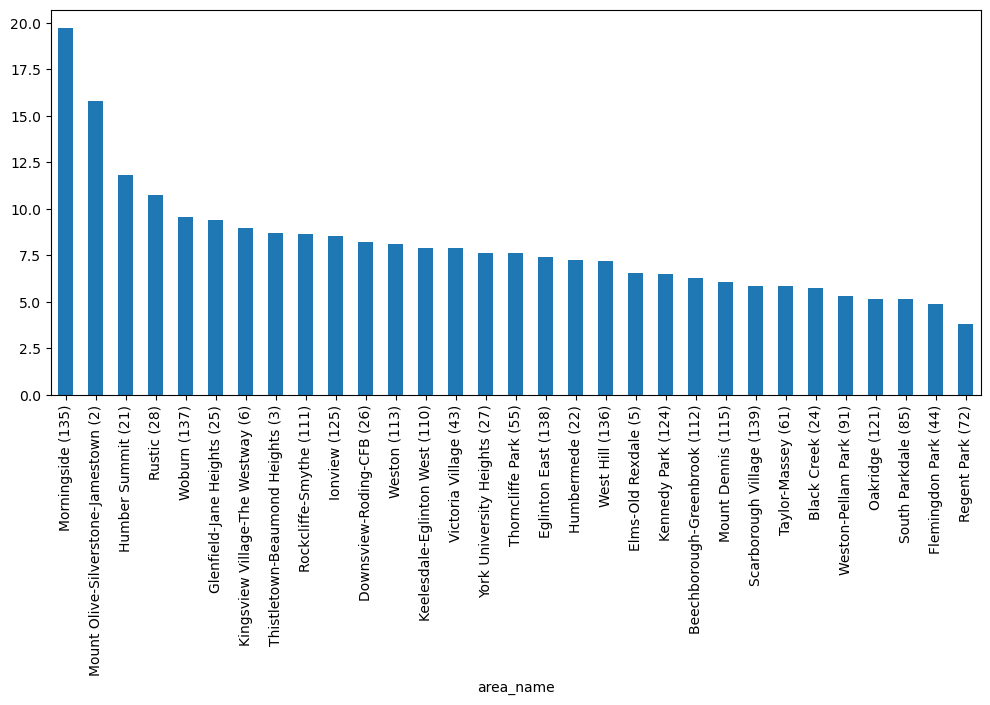

In [56]:
# plot bar plot
plt.figure(figsize=(12,5))
nia_address_bar = nia_address.groupby(['area_name'])['m_ttcstop_0'].mean()

nia_address_bar.sort_values(ascending=False).plot.bar()

# Plot Average Walking times to the Closest CCC for each Neighbourhood Improvement Area

Text(0.1, 0.08, 'Source: Toronto Open Data')

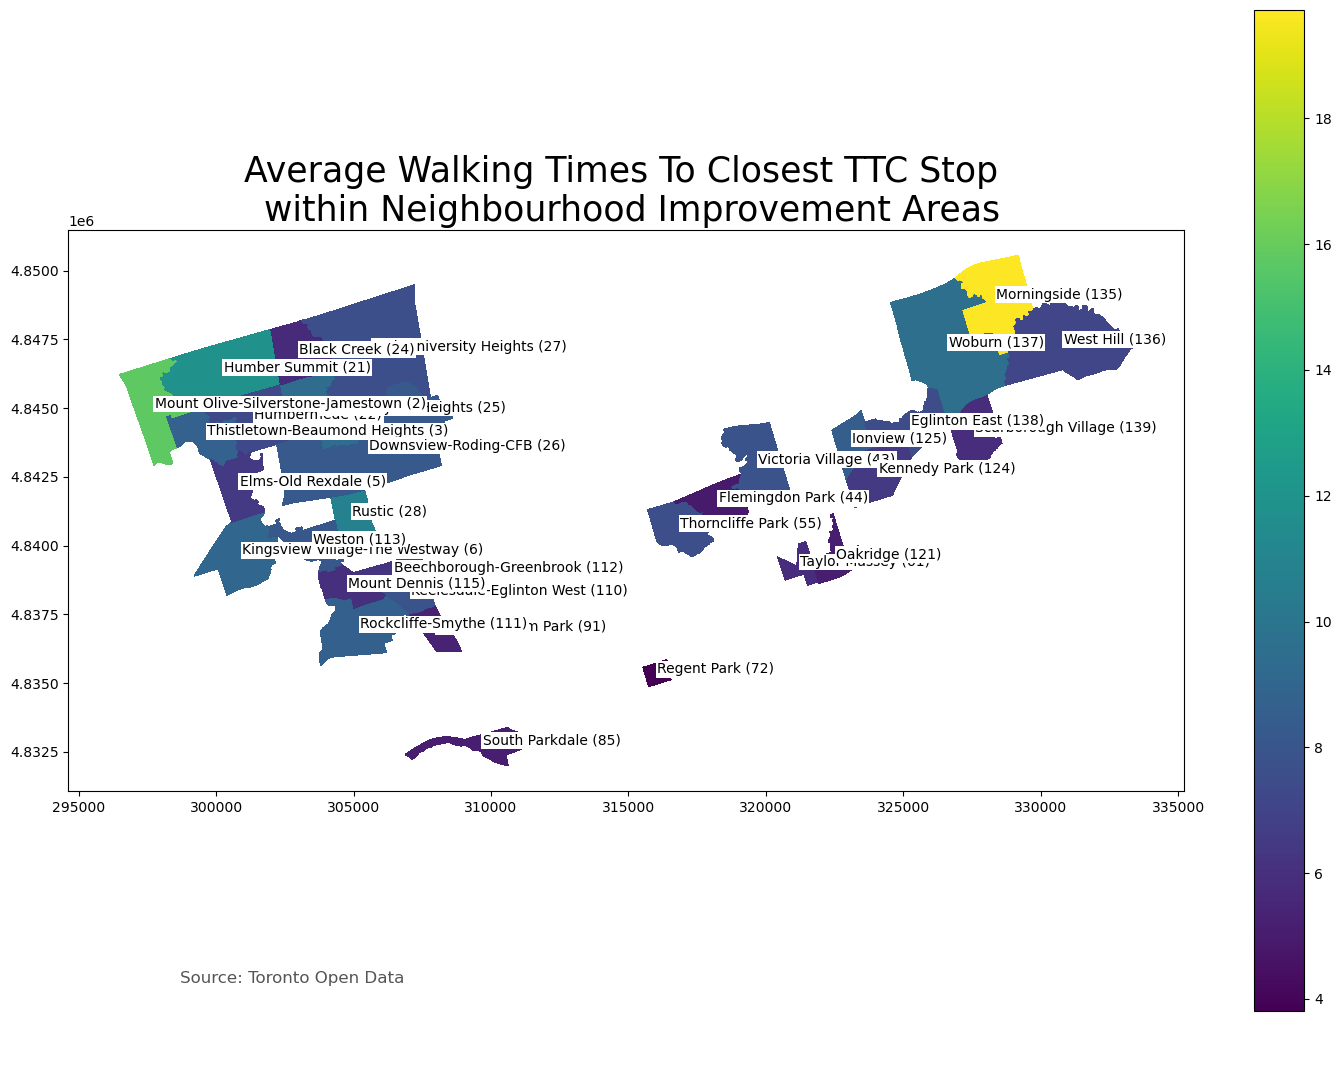

In [57]:
# plot Average Walking Times To Closest CCC in Neighbourhood Improvement Areas
ax = nia_address.plot(figsize=(18, 13), column='nia_addr_avg_min', legend=True)
ax.set_title('Average Walking Times To Closest CCC \n within Neighbourhood Improvement Areas', fontdict={'fontsize': '25', 'fontweight' : '3'})

# Plot labels and add a white box behind the label using the matplotlib bbox class.
for x, y, label in zip(nia_points.geometry.x, nia_points.geometry.y, nia_points["area_name"]):
    texts.append(plt.text(x, y, label, fontsize = 10, bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none')))
# create an annotation for the data source
ax.annotate('Source: Toronto Open Data',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Get bounds of each Neighbourhood Improvement Area polygon

We will list all of the Neighbourhood Improvement Areas. Select the index_left value corresponding to the Neighbourhood Improvement Area you want to display in the dataframe bell. We will use the bounding box function to obtain the polygon coordinates for each Neighbourhood Improvement Area. We will then use the bound box coordinates for a particular Neighbourhood Improvement Area polygon to show the walking times within the Neighbourhood Improvement Area.

In [58]:
# index_left and area_name
nia.area_name

0              York University Heights (27)
1          Thistletown-Beaumond Heights (3)
2                     Thorncliffe Park (55)
3                               Rustic (28)
4                 Scarborough Village (139)
5                       South Parkdale (85)
6                        Taylor-Massey (61)
7                        Humber Summit (21)
8                           Humbermede (22)
9                      Flemingdon Park (44)
10                            Ionview (125)
11              Glenfield-Jane Heights (25)
12                    Victoria Village (43)
13                          West Hill (136)
14                       Kennedy Park (124)
15        Kingsview Village-The Westway (6)
16           Keelesdale-Eglinton West (110)
17                       Mount Dennis (115)
18            Beechborough-Greenbrook (112)
19                           Oakridge (121)
20                      Eglinton East (138)
21                     Elms-Old Rexdale (5)
22                         Regen

In [59]:
# Get bounding box coordinates and area name for a particular Neighbourhood Improvement Area
# Pick index number from the list above and place it in the []
minx,miny,maxx,maxy = nia.bounds.iloc[4].values
# Pick the same index number from the list above and place it in the [] to get the area name
nia_area_name = nia.area_name.iloc[4]
nia_area_name

'Scarborough Village (139)'

# Plotting Neighbourhood Improvement Area using bounding box co-ordinates

Text(0.1, 0.05, 'Source: Toronto Open Data')

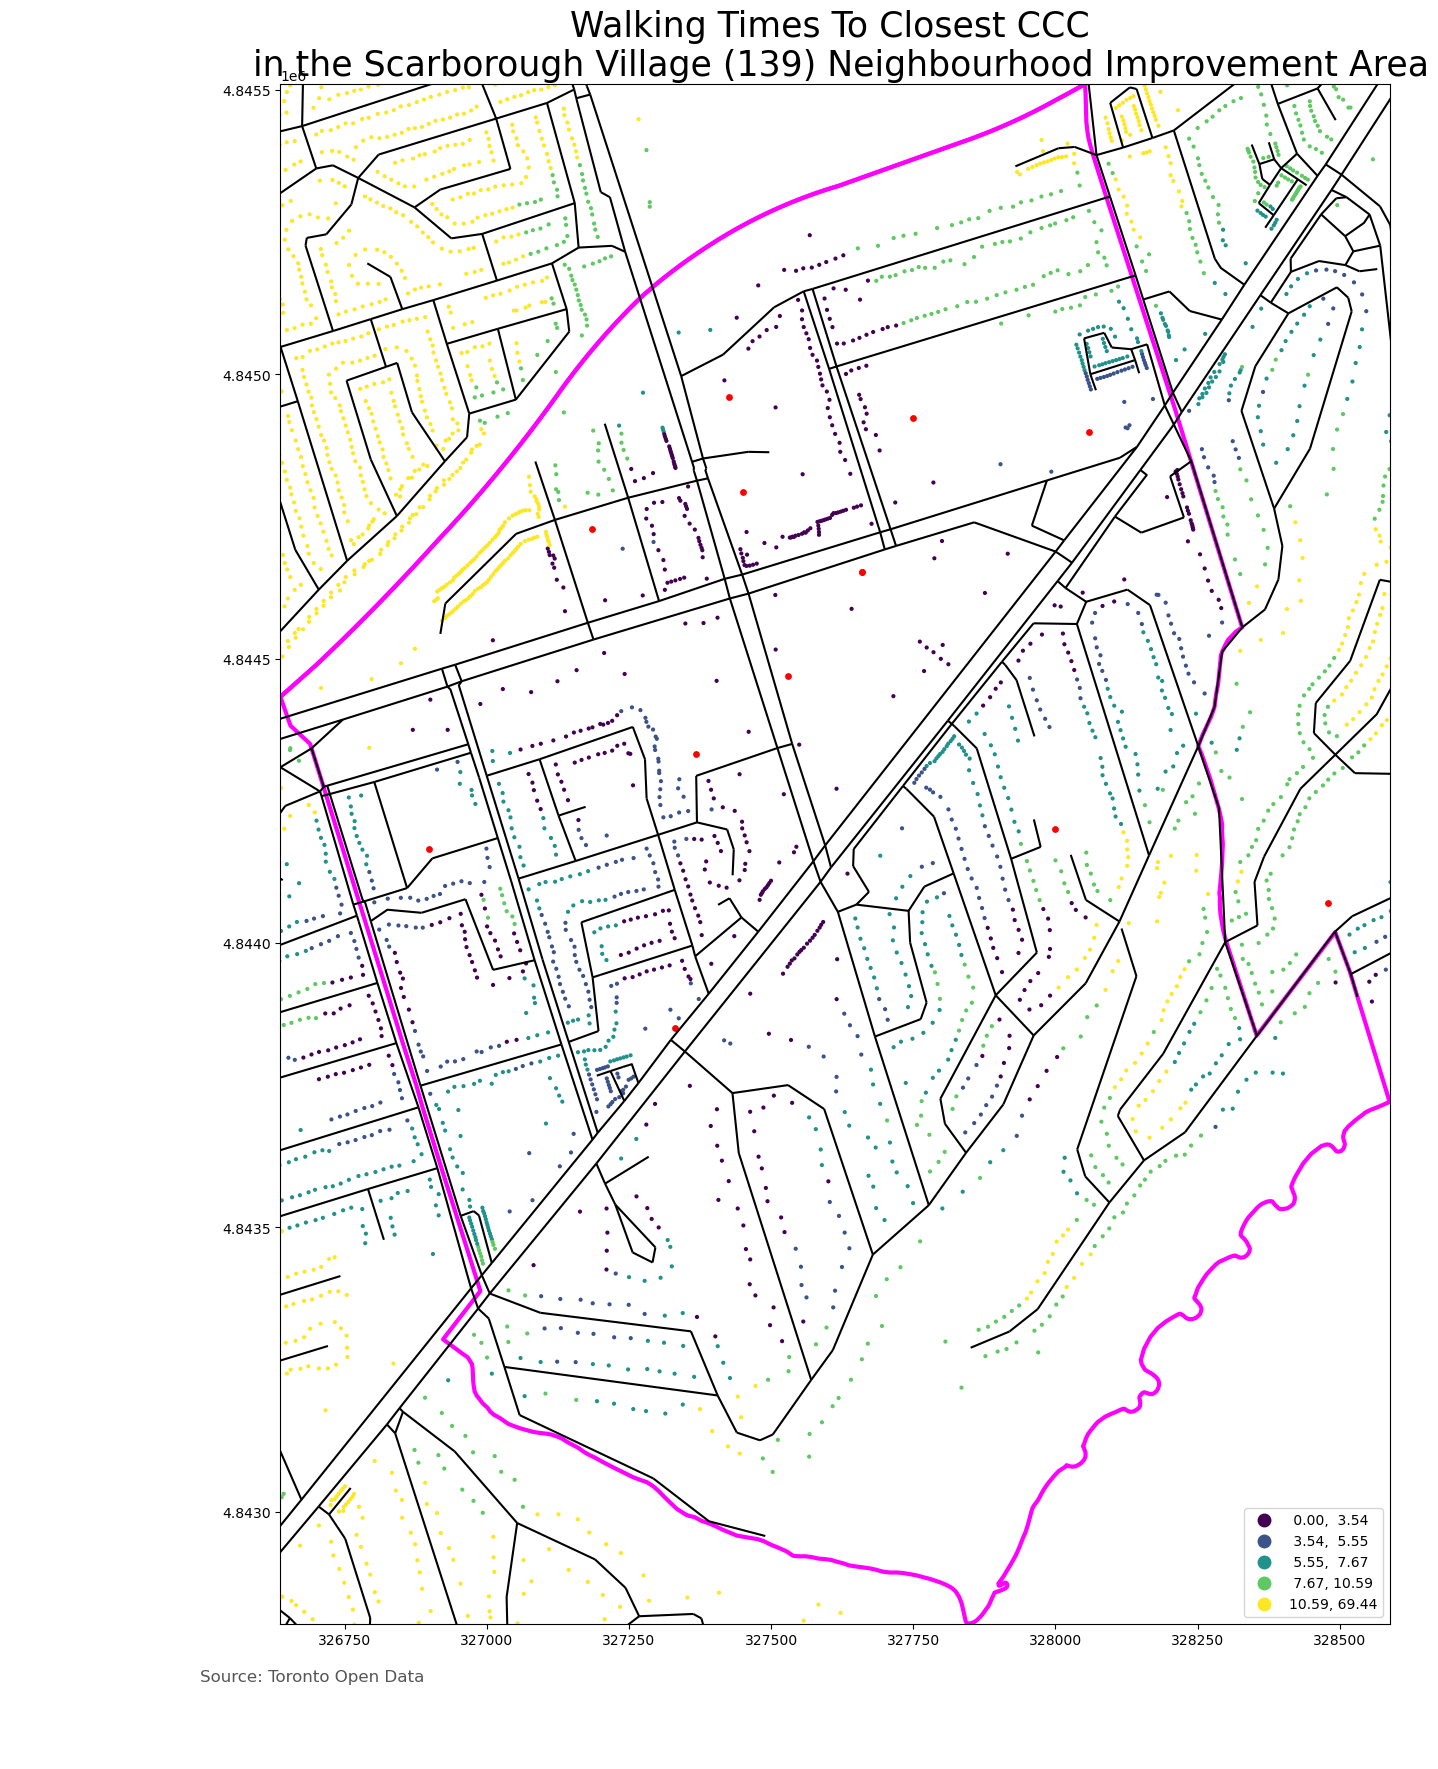

In [60]:
### plotting Neighbourhood Improvement Area using bounding box co-ordinates
#name = nia_area_name
ax = address.plot(figsize=(20, 20), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 4)
nia.plot(ax=ax, facecolor='none', edgecolor='magenta', linewidth=3)
ccc.plot(ax=ax, color='red', markersize =15)
pednet.plot(ax=ax,color='black', markersize =1)

# getting limits
ax.set(xlim=(minx, maxx), ylim=(miny, maxy))

# add a title
ax.set_title((('Walking Times To Closest CCC \n in the {0} Neighbourhood Improvement Area').format(nia_area_name)), fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: Toronto Open Data',xy=(0.1, .05),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

#option to save figure
#fig.savefig("./ccc_walkability.png", dpi=300)